$\Large{\textbf{Asynchronous Inertial Forward-Backward Splitting for Load Sharing}}$

$\textbf{Goal}$

A collection of $N$ controllable buildings, represented as linear dynamical systems, along with an energy storage 
system, represented as a one-state linear battery model, cooperate in order to track a signal. The signal corresponds
to the deviation of the planned power consumption of the buildings to their real-time consumption in addition to power deviations that are caused by uncontrollable loads. The mix of battery + buildings compensates for the aggregate deviation.  

$\textbf{Problem formulation}$

Track power residual signal for $T$ time instants (15 mins intervals) while operating the buildings and the battery within constraints. 

Can be formulated as

\begin{equation}
\begin{aligned}
&{\text{minimize}} && \sum_{t=0}^T\left(\frac{\alpha}{2}\|p^\mathrm{bess}(t) + \sum_{i=1}^N(p_i^\mathrm{cb}(t)-\hat{p}_i^\mathrm{cb}(t))-r(t)\|^2_2 + \sum_{i=1}^N g^\mathrm{cb}_i(p^{\mathrm{cb}}_i,u_i,x_i,y_i) + g^\mathrm{bess}(p^\mathrm{bess})\right)\enspace,
\end{aligned}
\end{equation}
with variables $p^\mathrm{bess}\in\mathbb{R}^T$ denoting the battery's power (generation or consumption), $p_i^\mathrm{cb}$ the $i^\mathrm{th}$ building's power consumption and $u_i,x_i,y_i$ being variables local to building $i$.






The problem comprises three types of terms:
* Tracking term $\frac{\alpha}{2}\|p^\mathrm{bess}(t) + \sum_{i=1}^N(p_i^\mathrm{cb}(t)-\hat{p}_i^\mathrm{cb}(t))-r(t)\|^2_2$: The signal $r$ is generated from the coordinator and should be tracked by the buildings and the battery, who can vary their consumption within a zone that is centered around their planned consumption (denoted by $p^{\mathrm{cb}}_i$ for building $i$) and defined by their operational constraints.
* Building (CB) $i$'s objective: \begin{equation}
g^\mathrm{cb}_i(p^{\mathrm{cb}}_i,u_i,x_i,y_i) := \Big\{\frac{1}{2}\|y_i(t)-T_i^\mathrm{ref}(t)\|^2_2
                                             \;\mid\;(p^{\mathrm{cb}}_i,u_i,x_i,y_i)\in\mathcal{C}^\mathrm{cb}_i \Big\}\enspace,
\end{equation}
where the zones' temperatures $y_i$ have to remain close to a reference $T_i^\mathrm{ref}$ while respecting operational and comfort constraints encoded in the convex set $\mathcal{C}^\mathrm{cb}_i$.
* Battery (BESS) objective: \begin{equation}
g^\mathrm{bess}(p^\mathrm{bess}) := \Big\{\frac{1}{2}\sum_{t=1}^T\|SOC(t)-SOC^\mathrm{ref}(t)\|^2_2
                                             \;\mid\;p^\mathrm{bess}\in\mathcal{C}^\mathrm{bess} \Big\}\enspace,
\end{equation}
where the battery's state of charge $SOC$ needs to remain close to a reference value $SOC^\mathrm{ref}$ while respecting power and capacity constraints encoded in the convex set $\mathcal{C}^\mathrm{bess}$.

$\textbf{Code}$

The code is organized in modules. The *battery* and *building* modules parse the data that have been generated in MATLAB. The *agentBESS* and *agentCB* modules contain all the information regarding the buildings in the form of *types* and *functions*. These are standalone entities containing private information. 

In the algorithm that follows, a *master* module acts as the coordinator. Its responsibility is to enforce the tracking part of the objective as described above.

Finally, the *pgm* and *async_inert_pgm* modules are the Proximal Gradient Method versions (synchronous and asynchronous) that solve the optimization problem.

The following cells set up the simulation, namely they perform the data parsing and initiate the constructors.

In [1]:
###################################################
## Packages, initial data parsing and set globals #
###################################################

# set up state-space models for two agents
include("building.jl")
using Buildings

include("battery.jl")
using Batteries

include("agentBESS.jl")
using AgentsBESS

include("parseData.jl")
using parseData

include("agentCB.jl")
using AgentsCB

include("master.jl")
using Masters

include("pgm.jl")
using ProximalGradient

include("async_inert_pgm.jl")
using AsynchronousProximalGradient

# general purpose packages
using JuMP
using Gurobi
using ECOS
using Distributions
using JLD
using DataFrames
using BenchmarkTools, Compat

# global variables
const N = 5   # agents
const T = 93  # time horizon
const δ = 0.01  # cost regularizer
const α = 1000.0  # tracking cost regularizer
Tref = 22.0  # reference temperature
Tend = 600.0  # simulation time in seconds

# initialize array of contructors for three (types of) builings and one battery
Building = Array{Buildings.Building}(3)
Battery = Array{Batteries.Battery}(1)

# initialize array of constructors for initial states and disturbance signals
x0 = Array{Any}(3)
w = Array{Any}(3)
ref = Array{Any}(1)

# initialize array of constructors for preconditioners
Γ_BESS = Array{Any}(1)
Γ_CB = Array{Any}(1)

1-element Array{Any,1}:
 #undef

In [2]:
#####################################################
## Parsing of signals and building / battery module #
#####################################################

# parse initial states, disturbance and reference signals and preconditioning matrices
x0, w, ref   = parseData.parseSignals(x0, w, ref)
Γ_BESS, Γ_CB = parseData.parsePreconditioners(Γ_BESS, Γ_CB)

# parse building and battery data
building = Buildings.parseBuildings(Building)
battery  = Batteries.parseBattery(Battery, N, T);


(15, 5)


(54, 18)


(57, 19)



In [3]:
#####################################################
## Aggregator CB constuctors                        # 
#####################################################

# initalize consumptions, state-space, constraints and optimization data structures
consume, ss, con, data = Array{Any}(1,N), Array{Any}(1,N), Array{Any}(1,N), Array{Any}(1,N)
AgentCB = Array{Any}(N)

# construct aggregators
types = convert(Array,readtable(string("data/type", ".dat"), separator = ',', header = false))
for i in 1:N
    consume[i], ss[i], con[i], data[i] =  AgentsCB.setupAggregator(1, building[types[i]], Γ_CB, δ)
    AgentCB[i]   = AgentsCB.Aggregator(1, consume[i], ss[i], con[i], data[i])
end

In [4]:
##############################################
## BESS constructor                          # 
##############################################

# initialize data structure and parameters
data   = Array{Any}(1)
SOC0   = 0.5*battery.SoCMax
SOCref = 0.8*battery.SoCMax
AgentBESS = Array{Any}(1)

# BESS aggregator (currently one battery)
system, data = AgentsBESS.setupBESS(battery, SOC0, SOCref, Γ_BESS)
AgentBESS = AgentsBESS.BESS(system, data)
typeof(AgentBESS)

AgentsBESS.BESS

In [5]:
##############################################
## Master constructor                        # 
##############################################

# dispatch plan corresponds to the baseline consumption
p_CB_hat = zeros(T,N)  # baseline consumption per building
p_CB_tot = zeros(T)    # total baseline consumption
for i in 1:N
    p_CB_hat[:,i] = AgentCB[i].consumption.baseline_electrical
    p_CB_tot = p_CB_tot + p_CB_hat[:,i]
end

# intialize selection matrices
S = Array{Any}(1)
E = Array{Any}(1)
Master = Array{Any}(1)

# constructor for the master
Master = Masters.setupMaster(S, E, ref, N, p_CB_tot)

Masters.Master(5, [1.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0], [-0.2253, -0.13693, -0.21021, -0.08137, -0.10065, -0.024183, -0.022123, 0.0049664, -0.15601, -0.12624  …  0.031261, 0.0028789, 0.036412, 0.02905, 0.09532, -0.002768, 0.023753, 0.087993, 0.21606, -0.013234], [-0.130526, -0.0426833, -0.115994, 0.0127743, -0.00656897, 0.0698937, 0.0719555, 0.0990496, -0.0619228, -0.032148  …  0.124922, 0.0965801, 0.130181, 0.122883, 0.189206, 0.0911706, 0.117757, 0.182086, 0.310238, 0.0809617])

In [6]:
# night and day times
night_times = collect([0:6*4-1; 22*4:24*4-1])
day_times = collect(6*4:22*4-1);

# initialize model
X0 = Array{Any}(N)  # initial state 
W  = Array{Any}(N)  # exogenous inputs

for i in 1:N
    if AgentCB[i].system.Nx == 15
        X0[i] = x0[1]
        W[i] = w[1]
    elseif AgentCB[i].system.Nx == 54
        X0[i] = x0[2]
        W[i] = w[2]
    elseif AgentCB[i].system.Nx == 57
        X0[i] = x0[3]
        W[i] = w[3]
    end
end

$\textbf{Solve the optimization problem centrally}$

The problem is solved centrally using the Gurobi optimizer with JuMP. The optimizers is used for verification of the distributed solution.

In [7]:
##################################################
## Solve one optimal control instance centrally  #
##################################################

t = 0
t0 = time_ns() 

agentModel = Model(solver=GurobiSolver())

@variable(agentModel, U[j=1:N,1:AgentCB[j].system.Nu,1:T])  # activation inputs for heating CBs
@variable(agentModel, X[j=1:N,1:AgentCB[j].system.Nx,1:T])  # internal states for CBs
@variable(agentModel, Y[j=1:N,1:AgentCB[j].system.Ny,1:T])  # temperatures for CBs
@variable(agentModel, p_CB[1:T,1:N])                        # total power consumption for CBs
@variable(agentModel, p_BESS[1:T])                          # total power consumption for BESS

X0  # initial states

# dynamics & equality contraints
for j = 1:N
    for i = 1:AgentCB[j].system.Nx
        @constraint(agentModel, X[j,i,1] == (sum(AgentCB[j].system.A[i,l]*X0[j][l] for l = 1:AgentCB[j].system.Nx) + sum(AgentCB[j].system.Bu[i,l]*U[j,l,1] for l = 1:AgentCB[j].system.Nu) + sum(AgentCB[j].system.Bw[i,l]*W[j][l,1] for l = 1:AgentCB[j].system.Nw) ) )
    end
    for i = 1:AgentCB[j].system.Ny
        @constraint(agentModel, Y[j,i,1] == sum(AgentCB[j].system.C[i,l]*X[j,l,1] for l = 1:AgentCB[j].system.Nx) )
    end
end

for j = 1:N
    for t = 1:T-1
        for i = 1:AgentCB[j].system.Nx
            @constraint(agentModel, X[j,i,t+1] == (sum(AgentCB[j].system.A[i,l]*X[j,l,t] for l = 1:AgentCB[j].system.Nx) + sum(AgentCB[j].system.Bu[i,l]*U[j,l,t+1] for l = 1:AgentCB[j].system.Nu) + sum(AgentCB[j].system.Bw[i,l]*W[j][l,t+1] for l = 1:AgentCB[j].system.Nw) ) )
        end

        for i = 1:AgentCB[j].system.Ny
            @constraint(agentModel, Y[j,i,t+1] == sum(AgentCB[j].system.C[i,l]*X[j,l,t+1] for l = 1:AgentCB[j].system.Nx) )
        end

        temp = 0
        for s = 1:AgentCB[j].system.Nu
            temp = temp + U[j,s,t]
        end
        @constraint(agentModel, p_CB[t,j] == temp/(1000*AgentCB[j].consumption.COP))

    end
    temp = 0
    for s = 1:AgentCB[j].system.Nu
        temp = temp + U[j,s,T]
    end
    @constraint(agentModel, p_CB[T,j] == temp/(1000*AgentCB[j].consumption.COP))
end
                                
# inequality constraints
for j = 1:N
    for t = 1:T
        if (t-1) in night_times
            for i = 1:AgentCB[j].system.Ny
                @constraint(agentModel, Y[j,i,t] >= AgentCB[j].constraints.outputNightMin[i])
                @constraint(agentModel, AgentCB[j].constraints.outputNightMax[i] >= Y[j,i,t])
            end
        elseif (t-1) in day_times
            for i = 1:AgentCB[j].system.Ny
                @constraint(agentModel, Y[j,i,t] >= AgentCB[j].constraints.outputDayMin[i])
                @constraint(agentModel, AgentCB[j].constraints.outputDayMax[i] >= Y[j,i,t])
            end
        end

        for i = 1:AgentCB[j].system.Nu # for all rows do the following
            @constraint(agentModel, 0*AgentCB[j].constraints.inputMin[i] <= U[j,i,t])
            @constraint(agentModel, U[j,i,t] <= AgentCB[j].constraints.inputMax[i])
        end
    end
end
   
v_p_CB = vec(p_CB)  
SE = Master.S*Master.E
M = [eye(T) SE]

for i = 1:T                                
    @constraint(agentModel, p_BESS[i] <= AgentBESS.system.pMax)  
    @constraint(agentModel, p_BESS[i] >= AgentBESS.system.pMin) 
    @constraint(agentModel, AgentBESS.system.AA_bess[i]*SOC0 + dot(AgentBESS.system.BB_bess[i,:],p_BESS) <= AgentBESS.system.SoCMax) 
    @constraint(agentModel, AgentBESS.system.AA_bess[i]*SOC0 + dot(AgentBESS.system.BB_bess[i,:],p_BESS) >= AgentBESS.system.SoCMin)
end
     
obj = 0;                                
obj = dot(p_BESS, 0.5*δ*(AgentBESS.system.BB_bess'*AgentBESS.system.BB_bess)*p_BESS) + δ*dot(p_BESS, (AgentBESS.system.BB_bess'*AgentBESS.data.c_bess)) + 0.5*δ*dot(AgentBESS.data.c_bess, AgentBESS.data.c_bess)   
obj += dot([p_BESS;v_p_CB], 0.5*α*(M'*M)*[p_BESS;v_p_CB]) - α*dot([p_BESS;v_p_CB], (M'*Master.ϵ_unc)) + 0.5*α*dot(Master.ϵ_unc, Master.ϵ_unc)  
                                    
for j = 1:N                                    
    obj += 0.5*δ*vecdot(p_CB[:,j]-AgentCB[j].consumption.baseline_electrical, p_CB[:,j]-AgentCB[j].consumption.baseline_electrical)
    for t = 1:T
        for i = 1:AgentCB[j].system.Ny
            obj += 0.5*δ*(Y[j,i,t]-Tref)*(Y[j,i,t]-Tref) 
        end
    end
end

@objective( agentModel, Min, obj )
solve(agentModel)  # solve optimization
gc()               # run garbage collector
                                
t = (time_ns()-t0)/1e9  # time solution

Academic license - for non-commercial use only
Optimize a model with 59613 rows, 37293 columns and 2008986 nonzeros
Model has 13578 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-10, 2e+01]
  Objective range  [2e-01, 3e+02]
  QObjective range [1e-06, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-05, 2e+04]
Presolve removed 29669 rows and 651 columns
Presolve time: 0.78s
Presolved: 29944 rows, 36732 columns, 1941834 nonzeros
Presolved model has 13578 quadratic objective terms
Ordering time: 0.64s

Barrier statistics:
 Free vars  : 14796
 AA' NZ     : 2.648e+06
 Factor NZ  : 3.750e+06 (roughly 60 MBytes of memory)
 Factor Ops : 5.169e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.74256722e+15 -2.74301942e+15  1.19e+07 9.25e+05  1.08e+09     2s
   1   3.21936452e+14 -3.22261904e+14  4.06e+06 3.16e+05  4.

41.486006671

In [8]:
# get optimizers
v_p_CB_opt = getvalue(v_p_CB)  # 
p_BESS_opt = getvalue(p_BESS)
p_CB_opt   = getvalue(p_CB)

soc = zeros(T)
for i = 1:T
    soc[i] = AgentBESS.system.AA_bess[i]*SOC0 + getvalue(dot(AgentBESS.system.BB_bess[i,:],p_BESS))
end
soc

93-element Array{Float64,1}:
 0.28041    
 0.179199   
 0.022487   
 0.0163553  
 2.20568e-12
 0.0135088  
 0.056599   
 0.131411   
 0.0423196  
 1.89881e-12
 1.07495e-12
 0.0163888  
 4.73954e-12
 ⋮          
 0.133945   
 0.141734   
 0.154558   
 0.138079   
 0.156887   
 0.166668   
 0.241668   
 0.211558   
 0.212329   
 0.280416   
 0.452374   
 0.395149   

In [9]:
#################################################
## Parses agents' optimization problems once    #
#################################################

optimizationModelProxCB = Array{Any}(N)  # initialize N prox minimization problems

for i in 1:N
    optimizationModelProxCB[i] = AgentsCB.setupProxCB(AgentCB[i], Tref, T, X0[i], W[i], night_times, day_times, δ);
end

optimizationModelProxBESS = Array{Any}(1)
optimizationModelProxBESS = AgentsBESS.setupProxBESS(AgentBESS, T, SOC0, δ);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


$\textbf{The Async simulation}$

In order to simulate the asycn implementation we have each agent execute its optimization step several times and consequently 
fit a normal distribution $\mathrm{SolveTime(i)}\sim\mathcal{N}(\mu_i,\sigma_i)$ to the sampled execution times. 
In this way we can estimate the time it will take to perform one local update by drawing a sample from its corresponding distribution.

First initialize with $t_i=\mathrm{SolveTime(i)}$, $t=0$ and some $T_{\mathrm{end}}>t$.

The algorithm reads as follows:
1. $j\leftarrow \mathrm{argmin}_i\;t_i$
2. $t\leftarrow t + t_j$
3. $t_j\leftarrow t + \mathrm{SolveTime(j)}$

Repeat until $t\geq T_{\mathrm{end}}$.


In [10]:
#################################################
## Benchmark proximal minimization problems     #
#################################################

# timings in Julia
bench_small    = BenchmarkTools.Trial           # run trial for small building
bench_med      = BenchmarkTools.Trial           # run trial for medium building
bench_large    = BenchmarkTools.Trial           # run trial for large building
TimeCB_small   = Distributions.Normal{Float64}  # fit normal distribution to solve times of small CB
TimeCB_med     = Distributions.Normal{Float64}  # fit normal distribution to solve times of medium CB
TimeCB_large   = Distributions.Normal{Float64}  # fit normal distribution to solve times of large CB

point = randn(T,1)

# solve a group of proximal optimization problems per type of agent 
# and fit normal distributions to the execution times (in sec)
i = 1
for i in 1:N
    if AgentCB[i].system.Nx == 15
        bench_small = @benchmark AgentsCB.solveProxCB(optimizationModelProxCB[i], point, sparse(AgentCB[i].data.Γ))
        TimeCB_small = fit(Normal, getfield(bench_small, :times)/1e9)
        break;
    end
end

for i in 1:N
    if AgentCB[i].system.Nx == 54
        bench_med = @benchmark AgentsCB.solveProxCB(optimizationModelProxCB[i], point, sparse(AgentCB[i].data.Γ))
        TimeCB_med = fit(Normal, getfield(bench_med, :times)/1e9)
        break;
    end
end

for i in 1:N
    if AgentCB[i].system.Nx == 57
        bench_large = @benchmark AgentsCB.solveProxCB(optimizationModelProxCB[i], point, sparse(AgentCB[i].data.Γ))
        TimeCB_large = fit(Normal, getfield(bench_large, :times)/1e9)
        break;
    end
end

# similarly benchmark BESS solve time (in sec)
point      = randn(T)
bench_BESS = BenchmarkTools.Trial
TimeBESS   = Distributions.Normal{Float64}
bench_BESS = @benchmark AgentsBESS.solveProxBESS(optimizationModelProxBESS, point, sparse(AgentBESS.data.Γ))
TimeBESS   = fit(Normal, getfield(bench_BESS, :times)/1e9)

Distributions.Normal{Float64}(μ=0.021840375379912663, σ=0.0017378520406081605)

In [11]:
#################################################
## Generate execution times for simulation      #
#################################################

execTimesMean = zeros(N+1)  # mean execution time per agent
execTimesVar = zeros(N+1)   # variance of execution time per agent
rndUpdate = zeros(N+1)      # sample solve time normal distribution 

# means and variances of solve time for each type of building
CB_small_μ = TimeCB_small.μ
CB_small_σ = TimeCB_small.σ
CB_medium_μ = TimeCB_med.μ
CB_medium_σ = TimeCB_med.σ
CB_large_μ = TimeCB_large.μ
CB_large_σ = TimeCB_large.σ
BESS_μ = TimeBESS.μ
BESS_σ = TimeBESS.σ

# execution time per building agent; samples are to be used to emulate the async updates
for i in 1:N
    if AgentCB[i].system.Nx == 15
        rndUpdate[i] = CB_small_μ + CB_small_σ*randn()
        execTimesMean[i] = CB_small_μ
        execTimesVar[i] = TimeCB_small.σ
    elseif AgentCB[i].system.Nx == 54
        rndUpdate[i] = CB_medium_μ + CB_medium_σ*randn()
        execTimesMean[i] = CB_medium_μ
        execTimesVar[i] = CB_medium_σ
    elseif AgentCB[i].system.Nx == 57
        rndUpdate[i] = CB_large_μ + CB_large_σ*randn()
        execTimesMean[i] = CB_large_μ
        execTimesVar[i] = CB_large_σ
    end
end

# execution time for battery agent
rndUpdate[N+1]     = BESS_μ + BESS_σ*randn() 
execTimesMean[N+1] = BESS_μ
execTimesVar[N+1]  = BESS_σ

# Generate next update times for agent
UpdateQueue = Dict{Int64,Float64}(zip(1:N+1, abs.(rndUpdate)));

ExecTimesTot  = UpdateQueue
ExecTimesMean = execTimesMean
ExecTimesVar  = execTimesVar

6-element Array{Float64,1}:
 0.0541129 
 0.00538671
 0.0517687 
 0.0517687 
 0.0541129 
 0.00173785

$\textbf{The Synchronous Proximal Gradient Method}$

The problem is first solved using the regular PGM. 

The gradient of the tracking term $\nabla f(p^\mathrm{cb},p^\mathrm{bess})$, where $f(p^\mathrm{cb},p^\mathrm{bess}):=\frac{\alpha}{2}\|p^\mathrm{bess}(t) + \sum_{i=1}^N(p_i^\mathrm{cb}(t)-\hat{p}_i^\mathrm{cb}(t))-r(t)\|^2_2$, is communicated to the agents (CBs and BESS). Each agent subsequently solves a $\textit{proximal minimization problem of the form}$

\begin{align}
&{\text{minimize}} && g_i(z_i) + \frac{1}{2\gamma}\|z_i-y\|_2^2\enspace,
\end{align}
with variable $z=(p^\mathrm{cb},p^\mathrm{bess})$, $\gamma>0$ an admissible stepsize and $y = z_i^k - γ∇_if(z^k)$.

In [12]:
#########################################################
## Solve one optimal control instance: Synchronous PGM  #
#########################################################

# initialize PGM (call to constructor)
pgm_u, pgm_y, pgm_x, pgm_v, pgm_P_CB, pgm_P_CB_prev, pgm_P_BESS, pgm_P_BESS_prev, pgm_RES = ProximalGradient.setupPGM(AgentCB, N, T)
pgm_init = ProximalGradient.PGM(pgm_u, pgm_y, pgm_x, pgm_v, pgm_P_CB, pgm_P_CB_prev, pgm_P_BESS, pgm_P_BESS_prev, pgm_RES)

# solve
β = 0.0  # heavy-ball acceleration
η = 0.9  # under-relaxation
pgm, T1 = ProximalGradient.AlgoPGM(pgm_init, N, T, Tend, SOC0, ExecTimesTot, optimizationModelProxCB, optimizationModelProxBESS, AgentBESS, AgentCB, Master, p_BESS_opt, v_p_CB_opt, η, β, δ, α);

"Time is: 16.13228704796914"

"Residual: 0.8732668660341232"

"Time is: 32.26457409593828"

"Residual: 0.7918462073032135"

"Time is: 48.39686114390745"

"Residual: 0.7392102661980797"

"Time is: 64.52914819187662"

"Residual: 0.7010688851143378"

"Time is: 80.66143523984572"

"Residual: 0.6710956256304594"

"Time is: 96.79372228781482"

"Residual: 0.645989563640642"

"Time is: 112.92600933578392"

"Residual: 0.6241222309972551"

"Time is: 129.05829638375303"

"Residual: 0.6048097544863436"

"Time is: 145.19058343172213"

"Residual: 0.5875682577634118"

"Time is: 161.32287047969123"

"Residual: 0.5720425089300596"

"Time is: 177.45515752766033"

"Residual: 0.5579706117018675"

"Time is: 193.58744457562943"

"Residual: 0.5451311568765034"

"Time is: 209.71973162359853"

"Residual: 0.5333433919977144"

"Time is: 225.85201867156763"

"Residual: 0.5224231361547046"

"Time is: 241.98430571953674"

"Residual: 0.5122409714430636"

"Time is: 258.1165927675059"

"Residual: 0.5027228648551991"

"Time is: 274.2488798154753"

"Residual: 0.4937934547316668"

"Time is: 290.38116686344466"

"Residual: 0.48538120625859627"

"Time is: 306.51345391141405"

"Residual: 0.477411602558237"

"Time is: 322.64574095938343"

"Residual: 0.46984178351081374"

"Time is: 338.7780280073528"

"Residual: 0.46263546112849396"

"Time is: 354.9103150553222"

"Residual: 0.4557577672762028"

"Time is: 371.0426021032916"

"Residual: 0.4491744502133608"

"Time is: 387.17488915126097"

"Residual: 0.44284519260690625"

"Time is: 403.30717619923035"

"Residual: 0.43674762221084495"

"Time is: 419.43946324719974"

"Residual: 0.43086659645804043"

"Time is: 435.5717502951691"

"Residual: 0.42518915692453163"

"Time is: 451.7040373431385"

"Residual: 0.4197043678566983"

"Time is: 467.8363243911079"

"Residual: 0.41440252890269763"

"Time is: 483.9686114390773"

"Residual: 0.40927300054333954"

"Time is: 500.10089848704666"

"Residual: 0.4043061129163674"

"Time is: 516.233185535016"

"Residual: 0.3994930473901314"

"Time is: 532.3654725829854"

"Residual: 0.39482595683047744"

"Time is: 548.4977596309548"

"Residual: 0.3902973935151739"

"Time is: 564.6300466789241"

"Residual: 0.38590059709658076"

"Time is: 580.7623337268935"

"Residual: 0.3816293158643277"

"Time is: 596.8946207748629"

"Residual: 0.3774778219406977"

$\textbf{The Asynchronous Proximal Gradient Method}$

At each global clock count $k$ one agent $i_k$ updates. The update corresponds to the solution of the prox problem

\begin{align}
&{\text{minimize}} && g_{i_k}(z_{i_k}) + \frac{1}{2\gamma}\|z_{i_k}-y_{i_k}\|_2^2\enspace,
\end{align}
where $y_{i_k} = z_{i_k}^k - γ∇_if(z^{i_k}_\mathrm{read})$ and $z^{i_k}_\mathrm{read}$ corresponds to an outdated version of the decision vector $z$, when agent $i_k$ last read it. 

In [31]:
############################################################################
## Solve one optimal control instance: Coordinate descent asynchronous PGM #
############################################################################

# initialize AsInPGM (call to constructor)
async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev = AsynchronousProximalGradient.setupAsInPGM(AgentCB, N, T)
async_pgm_init = AsynchronousProximalGradient.AsInPGM(async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev)

# reset times
UpdateQueue  = Dict{Int64,Float64}(zip(1:N+1, abs.(rndUpdate)))
ExecTimesTot = UpdateQueue

# solve
η = 0.9  # under-relaxation
β = 0.0  # heavy-ball acceleration
as_pgm, T2, NoUpdates2 = AsynchronousProximalGradient.AlgoAsInPGM(true, false, async_pgm_init, N, T, Tend, ExecTimesTot, ExecTimesMean, ExecTimesVar, optimizationModelProxCB, optimizationModelProxBESS, AgentBESS, AgentCB, Master, p_BESS_opt, v_p_CB_opt, η, β, δ, α);

LoadError: [91mInterruptException:[39m

$\textbf{The Asynchronous 'Aggregated' Proximal Gradient Method}$

Similar to the previous algorithm, with the difference that $\textit{all}$ coordinates of the decision vector $z$ are updated at each iteration $k$. For the coordinates $j\neq i_k$, the last-computed values are used to perform the update.

In [64]:
############################################################################
## Solve one optimal control instance: 'Aggregated' Asynchronous PGM       #
############################################################################

# Initialize AsInPGM (call to constructor)
async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev = AsynchronousProximalGradient.setupAsInPGM(AgentCB, N, T)
async_pgm_init = AsynchronousProximalGradient.AsInPGM(async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev)

# solve
η = 0.9  # under-relaxation
β = 0.0  # heavy-ball acceleration
UpdateQueue  = Dict{Int64,Float64}(zip(1:N+1, abs.(rndUpdate)))
ExecTimesTot = UpdateQueue
as_agg_pgm, T3, NoUpdates3 = AsynchronousProximalGradient.AlgoAsInPGM(false, false, async_pgm_init, N, T, Tend, ExecTimesTot, ExecTimesMean, ExecTimesVar, optimizationModelProxCB, optimizationModelProxBESS, AgentBESS, AgentCB, Master, p_BESS_opt, v_p_CB_opt, η, β, δ, α);

"Update queue: [2.26406, 1.53919, 2.19247, 1.67719, 1.53463, 2.7652]"

"Time of the next update: 1.5346263522540686"

"Next index to update: 6"

"Time is: 1.5346263522540686"

"Residual: 1.3578311686747804"

"Update queue: [3.23205, 3.09199, 3.36919, 3.02596, 3.0384, 4.24337]"

"Time of the next update: 3.025959180214288"

"Next index to update: 5"

"Time is: 3.025959180214288"

"Residual: 0.8078664984764907"

"Update queue: [5.48967, 4.55036, 5.64624, 4.7525, 4.52374, 5.86901]"

"Time of the next update: 4.523739176631655"

"Next index to update: 6"

"Time is: 4.523739176631655"

"Residual: 0.7286493472481147"

"Update queue: [6.6028, 6.08904, 6.66076, 6.14833, 6.00171, 7.48524]"

"Time of the next update: 6.001709265132623"

"Next index to update: 6"

"Time is: 6.001709265132623"

"Residual: 0.6621788939616368"

"Update queue: [7.63918, 7.56073, 7.75421, 7.6146, 7.54447, 9.01139]"

"Time of the next update: 7.544466335896438"

"Next index to update: 6"

"Time is: 7.544466335896438"

"Residual: 0.6227931708493433"

"Update queue: [9.86804, 9.01439, 9.94034, 9.10443, 9.02421, 10.3923]"

"Time of the next update: 9.014394267318266"

"Next index to update: 2"

"Time is: 9.014394267318266"

"Residual: 0.5827497844112048"

"Update queue: [11.0001, 10.5415, 11.0687, 10.6212, 10.4982, 11.9398]"

"Time of the next update: 10.498162814938846"

"Next index to update: 6"

"Time is: 10.498162814938846"

"Residual: 0.5495481761391785"

"Update queue: [12.1309, 12.0772, 12.1958, 12.117, 12.0066, 13.4061]"

"Time of the next update: 12.006573770630611"

"Next index to update: 6"

"Time is: 12.006573770630611"

"Residual: 0.5256274604241146"

"Update queue: [14.3675, 13.5313, 14.4691, 13.6043, 13.4758, 14.9357]"

"Time of the next update: 13.475758925406193"

"Next index to update: 6"

"Time is: 13.475758925406193"

"Residual: 0.49924953714479725"

"Update queue: [15.4735, 14.9754, 15.6007, 15.0789, 14.9813, 16.3365]"

"Time of the next update: 14.975380035311003"

"Next index to update: 2"

"Time is: 14.975380035311003"

"Residual: 0.48005414969236293"

"Update queue: [16.5575, 16.5162, 16.6953, 16.5113, 16.4746, 17.8742]"

"Time of the next update: 16.47461193123742"

"Next index to update: 6"

"Time is: 16.47461193123742"

"Residual: 0.46075493587400096"

"Update queue: [18.7895, 17.9632, 18.7921, 18.2092, 17.9612, 19.4999]"

"Time of the next update: 17.961166227001357"

"Next index to update: 6"

"Time is: 17.961166227001357"

"Residual: 0.4433155460844149"

"Update queue: [19.8952, 19.5121, 19.8349, 19.8533, 19.4661, 19.4999]"

"Time of the next update: 19.466138600337615"

"Next index to update: 6"

"Time is: 19.466138600337615"

"Residual: 0.432710169147981"

"Update queue: [21.0405, 20.9599, 22.0355, 21.4708, 20.9682, 21.0378]"

"Time of the next update: 20.959946816053463"

"Next index to update: 2"

"Time is: 20.959946816053463"

"Residual: 0.41960364223824587"

"Update queue: [23.1592, 22.4715, 23.215, 23.1078, 22.4369, 22.4879]"

"Time of the next update: 22.436922746787868"

"Next index to update: 6"

"Time is: 22.436922746787868"

"Residual: 0.40662799426075286"

"Update queue: [24.1869, 23.9289, 24.3645, 24.6148, 23.9467, 24.0276]"

"Time of the next update: 23.92893242335278"

"Next index to update: 2"

"Time is: 23.92893242335278"

"Residual: 0.39584118542948477"

"Update queue: [26.3993, 25.4522, 25.4813, 26.2056, 25.3992, 25.4956]"

"Time of the next update: 25.399181265929332"

"Next index to update: 6"

"Time is: 25.399181265929332"

"Residual: 0.38588306660917143"

"Update queue: [27.532, 26.9, 27.7009, 27.7024, 26.8881, 27.1557]"

"Time of the next update: 26.88807639760703"

"Next index to update: 6"

"Time is: 26.88807639760703"

"Residual: 0.3757751907326296"

"Update queue: [28.7298, 28.4192, 28.8256, 29.2966, 28.3609, 28.6104]"

"Time of the next update: 28.3608848649192"

"Next index to update: 6"

"Time is: 28.3608848649192"

"Residual: 0.36769164658344794"

"Update queue: [30.8783, 29.8867, 30.9471, 30.7415, 29.8498, 30.182]"

"Time of the next update: 29.849780444917585"

"Next index to update: 6"

"Time is: 29.849780444917585"

"Residual: 0.35971743643748677"

"Update queue: [31.9762, 31.3516, 32.0294, 32.2435, 31.3228, 31.7283]"

"Time of the next update: 31.32284476248226"

"Next index to update: 6"

"Time is: 31.32284476248226"

"Residual: 0.3520131497868062"

"Update queue: [33.1432, 32.8581, 33.0838, 33.7576, 32.8348, 33.293]"

"Time of the next update: 32.834818000728305"

"Next index to update: 6"

"Time is: 32.834818000728305"

"Residual: 0.3454999125866739"

"Update queue: [35.37, 34.3152, 35.1896, 35.33, 34.3199, 35.0223]"

"Time of the next update: 34.31520624099513"

"Next index to update: 2"

"Time is: 34.31520624099513"

"Residual: 0.33880060084335906"

"Update queue: [36.4882, 35.8375, 36.3723, 36.7528, 35.8089, 36.5927]"

"Time of the next update: 35.80892355620515"

"Next index to update: 6"

"Time is: 35.80892355620515"

"Residual: 0.33288030946760827"

"Update queue: [37.5674, 37.2858, 37.5123, 38.3508, 37.2986, 37.9583]"

"Time of the next update: 37.2857741938225"

"Next index to update: 2"

"Time is: 37.2857741938225"

"Residual: 0.32769410338888333"

"Update queue: [39.8383, 38.8044, 39.5747, 40.0477, 38.7468, 39.497]"

"Time of the next update: 38.74680640894491"

"Next index to update: 6"

"Time is: 38.74680640894491"

"Residual: 0.3224155098859766"

"Update queue: [40.9779, 40.2751, 40.5922, 41.5853, 40.256, 41.0663]"

"Time of the next update: 40.25601812568671"

"Next index to update: 6"

"Time is: 40.25601812568671"

"Residual: 0.31761187407875824"

"Update queue: [42.1251, 41.8092, 41.7579, 43.0632, 41.7238, 42.4758]"

"Time of the next update: 41.72378864325938"

"Next index to update: 6"

"Time is: 41.72378864325938"

"Residual: 0.3133820415930325"

"Update queue: [43.2341, 43.2617, 44.0011, 44.6185, 43.2242, 44.0779]"

"Time of the next update: 43.224211351920104"

"Next index to update: 6"

"Time is: 43.224211351920104"

"Residual: 0.3089722594820713"

"Update queue: [45.3524, 44.7842, 45.0442, 46.069, 44.6963, 45.4285]"

"Time of the next update: 44.696337765027344"

"Next index to update: 6"

"Time is: 44.696337765027344"

"Residual: 0.3050537719774632"

"Update queue: [46.4555, 46.209, 47.2919, 47.5723, 46.2137, 47.0323]"

"Time of the next update: 46.208956536885886"

"Next index to update: 2"

"Time is: 46.208956536885886"

"Residual: 0.30122016668450163"

"Update queue: [48.5853, 47.754, 48.4217, 49.1738, 47.6886, 48.4745]"

"Time of the next update: 47.688629118295445"

"Next index to update: 6"

"Time is: 47.688629118295445"

"Residual: 0.29753128453957217"

"Update queue: [49.6435, 49.2183, 49.5291, 49.1738, 49.1883, 49.9617]"

"Time of the next update: 49.17376088844446"

"Next index to update: 5"

"Time is: 49.17376088844446"

"Residual: 0.29463698733732524"

"Update queue: [50.6915, 50.669, 51.7627, 50.8007, 50.6637, 51.6152]"

"Time of the next update: 50.663729631986016"

"Next index to update: 6"

"Time is: 50.663729631986016"

"Residual: 0.29206789167882985"

"Update queue: [52.8502, 52.2146, 52.8447, 52.3718, 52.1393, 53.1265]"

"Time of the next update: 52.139299901850784"

"Next index to update: 6"

"Time is: 52.139299901850784"

"Residual: 0.2888026802554235"

"Update queue: [53.968, 53.6448, 53.9548, 53.8972, 53.6287, 54.5682]"

"Time of the next update: 53.62874093793152"

"Next index to update: 6"

"Time is: 53.62874093793152"

"Residual: 0.28597244483625156"

"Update queue: [56.2368, 55.0927, 56.1513, 55.3404, 55.1095, 56.0564]"

"Time of the next update: 55.092666622373315"

"Next index to update: 2"

"Time is: 55.092666622373315"

"Residual: 0.2831447975836995"

"Update queue: [57.2941, 56.6617, 57.2635, 56.9036, 56.6172, 57.6388]"

"Time of the next update: 56.617190807637805"

"Next index to update: 6"

"Time is: 56.617190807637805"

"Residual: 0.28038919239131543"

"Update queue: [58.3631, 58.102, 58.378, 58.3273, 58.1094, 59.0783]"

"Time of the next update: 58.101994675896364"

"Next index to update: 2"

"Time is: 58.101994675896364"

"Residual: 0.2779186304665653"

"Update queue: [60.5395, 59.5611, 60.601, 59.8631, 59.5677, 60.6815]"

"Time of the next update: 59.56109331067713"

"Next index to update: 2"

"Time is: 59.56109331067713"

"Residual: 0.27542051901689624"

"Update queue: [61.6364, 61.0858, 61.6831, 61.4746, 61.0674, 62.2871]"

"Time of the next update: 61.06739680191902"

"Next index to update: 6"

"Time is: 61.06739680191902"

"Residual: 0.27305082440149653"

"Update queue: [62.6768, 62.5487, 62.8293, 63.0509, 62.5548, 63.8642]"

"Time of the next update: 62.548719928949225"

"Next index to update: 2"

"Time is: 62.548719928949225"

"Residual: 0.2708732321656192"

"Update queue: [64.8781, 64.0169, 65.0244, 64.4816, 64.0358, 65.4352]"

"Time of the next update: 64.01687041569711"

"Next index to update: 2"

"Time is: 64.01687041569711"

"Residual: 0.2687030169513833"

"Update queue: [65.9873, 65.5531, 66.095, 66.0683, 65.512, 67.1219]"

"Time of the next update: 65.51197027612055"

"Next index to update: 6"

"Time is: 65.51197027612055"

"Residual: 0.2667911369249536"

"Update queue: [67.0293, 67.1031, 67.2247, 67.6256, 67.0276, 67.1219]"

"Time of the next update: 67.02764194337216"

"Next index to update: 6"

"Time is: 67.02764194337216"

"Residual: 0.26541238784536864"

"Update queue: [69.4292, 68.5272, 69.4353, 69.0612, 68.508, 68.7995]"

"Time of the next update: 68.50798939244513"

"Next index to update: 6"

"Time is: 68.50798939244513"

"Residual: 0.26339461821757426"

"Update queue: [70.4975, 70.0265, 70.4948, 70.6136, 70.0048, 70.4363]"

"Time of the next update: 70.00479638153497"

"Next index to update: 6"

"Time is: 70.00479638153497"

"Residual: 0.2614639607782095"

"Update queue: [71.6396, 71.5829, 71.5508, 72.0663, 71.4996, 71.8265]"

"Time of the next update: 71.49959661017195"

"Next index to update: 6"

"Time is: 71.49959661017195"

"Residual: 0.259629168547057"

"Update queue: [73.943, 73.0386, 73.8192, 73.5432, 72.9821, 73.2595]"

"Time of the next update: 72.98208146219739"

"Next index to update: 6"

"Time is: 72.98208146219739"

"Residual: 0.25782455677564386"

"Update queue: [75.0087, 74.5199, 74.9419, 75.2312, 74.495, 74.8441]"

"Time of the next update: 74.49496125441917"

"Next index to update: 6"

"Time is: 74.49496125441917"

"Residual: 0.256076906528494"

"Update queue: [76.0729, 76.0537, 76.0774, 76.788, 75.9665, 76.3775]"

"Time of the next update: 75.96649685364324"

"Next index to update: 6"

"Time is: 75.96649685364324"

"Residual: 0.25439642086151204"

"Update queue: [78.2683, 77.4364, 78.2715, 78.3387, 77.4497, 77.977]"

"Time of the next update: 77.43644320057759"

"Next index to update: 2"

"Time is: 77.43644320057759"

"Residual: 0.2526952944210081"

"Update queue: [79.3435, 78.9638, 79.3186, 79.8347, 78.9189, 79.5952]"

"Time of the next update: 78.91885690921926"

"Next index to update: 6"

"Time is: 78.91885690921926"

"Residual: 0.2510985790433798"

"Update queue: [80.4407, 80.4082, 81.5727, 81.3989, 80.4214, 81.1218]"

"Time of the next update: 80.40817277449823"

"Next index to update: 2"

"Time is: 80.40817277449823"

"Residual: 0.24957001173658455"

"Update queue: [82.6514, 81.8706, 82.7157, 82.8838, 81.8777, 82.5083]"

"Time of the next update: 81.87055745331375"

"Next index to update: 2"

"Time is: 81.87055745331375"

"Residual: 0.24800640933606533"

"Update queue: [83.6837, 83.4135, 83.8186, 84.4204, 83.3737, 84.0175]"

"Time of the next update: 83.37373279259351"

"Next index to update: 6"

"Time is: 83.37373279259351"

"Residual: 0.24655900814563353"

"Update queue: [85.9696, 84.8683, 84.9502, 85.946, 84.8901, 85.6941]"

"Time of the next update: 84.86831736496092"

"Next index to update: 2"

"Time is: 84.86831736496092"

"Residual: 0.24515313236424796"

"Update queue: [87.0357, 86.3942, 87.1564, 87.5285, 86.3631, 87.1641]"

"Time of the next update: 86.3631117496325"

"Next index to update: 6"

"Time is: 86.3631117496325"

"Residual: 0.24370164776683384"

"Update queue: [88.1924, 87.92, 88.3175, 89.1886, 87.8609, 88.7591]"

"Time of the next update: 87.86088046088645"

"Next index to update: 6"

"Time is: 87.86088046088645"

"Residual: 0.24244092488959612"

"Update queue: [89.3751, 89.3856, 90.3941, 90.6636, 89.3659, 90.4371]"

"Time of the next update: 89.36590354698107"

"Next index to update: 6"

"Time is: 89.36590354698107"

"Residual: 0.24113843373197758"

"Update queue: [91.5489, 90.8583, 91.4786, 92.1264, 90.8663, 91.999]"

"Time of the next update: 90.85830006966539"

"Next index to update: 2"

"Time is: 90.85830006966539"

"Residual: 0.2398254589801604"

"Update queue: [92.667, 92.4037, 92.4167, 93.7126, 92.3416, 93.5329]"

"Time of the next update: 92.34159768975863"

"Next index to update: 6"

"Time is: 92.34159768975863"

"Residual: 0.23860974867833123"

"Update queue: [94.8403, 93.8418, 94.6201, 95.0904, 93.8269, 95.1416]"

"Time of the next update: 93.82685670733912"

"Next index to update: 6"

"Time is: 93.82685670733912"

"Residual: 0.23744485132084178"

"Update queue: [95.9926, 95.3778, 95.7005, 96.6994, 95.3137, 96.6553]"

"Time of the next update: 95.31368165907192"

"Next index to update: 6"

"Time is: 95.31368165907192"

"Residual: 0.23624987417180338"

"Update queue: [97.0819, 96.8219, 97.8971, 98.2773, 96.815, 98.108]"

"Time of the next update: 96.81500004942495"

"Next index to update: 6"

"Time is: 96.81500004942495"

"Residual: 0.2351907763039206"

"Update queue: [99.1378, 98.3399, 98.9335, 99.8531, 98.2943, 99.6843]"

"Time of the next update: 98.29428214617514"

"Next index to update: 6"

"Time is: 98.29428214617514"

"Residual: 0.23420586519373832"

"Update queue: [100.229, 99.8472, 100.066, 99.8531, 99.8161, 101.273]"

"Time of the next update: 99.81607723001893"

"Next index to update: 6"

"Time is: 99.81607723001893"

"Residual: 0.23340614353366096"

"Update queue: [102.468, 101.301, 102.308, 101.477, 101.304, 102.835]"

"Time of the next update: 101.30116447810728"

"Next index to update: 2"

"Time is: 101.30116447810728"

"Residual: 0.23245281402637605"

"Update queue: [103.589, 102.833, 103.433, 102.984, 102.821, 102.835]"

"Time of the next update: 102.82090943599933"

"Next index to update: 6"

"Time is: 102.82090943599933"

"Residual: 0.23165958411583296"

"Update queue: [104.654, 104.374, 104.47, 104.547, 104.319, 104.394]"

"Time of the next update: 104.31913273072254"

"Next index to update: 6"

"Time is: 104.31913273072254"

"Residual: 0.23058447054188047"

"Update queue: [106.812, 105.836, 106.605, 106.125, 105.827, 105.839]"

"Time of the next update: 105.82726119823029"

"Next index to update: 6"

"Time is: 105.82726119823029"

"Residual: 0.22955476883776385"

"Update queue: [107.867, 107.343, 107.747, 107.604, 107.308, 107.373]"

"Time of the next update: 107.30785414281847"

"Next index to update: 6"

"Time is: 107.30785414281847"

"Residual: 0.22852826933483014"

"Update queue: [109.09, 108.88, 108.946, 109.234, 108.8, 108.949]"

"Time of the next update: 108.80015538568138"

"Next index to update: 6"

"Time is: 108.80015538568138"

"Residual: 0.2275170998947602"

"Update queue: [111.26, 110.32, 111.064, 110.94, 110.292, 110.457]"

"Time of the next update: 110.29232987487912"

"Next index to update: 6"

"Time is: 110.29232987487912"

"Residual: 0.2265311759167085"

"Update queue: [112.381, 111.859, 112.156, 112.369, 111.797, 111.996]"

"Time of the next update: 111.79741049991081"

"Next index to update: 6"

"Time is: 111.79741049991081"

"Residual: 0.22555853674502635"

"Update queue: [113.476, 113.312, 114.318, 113.86, 113.303, 113.544]"

"Time of the next update: 113.30337826609089"

"Next index to update: 6"

"Time is: 113.30337826609089"

"Residual: 0.22461744794087146"

"Update queue: [115.731, 114.785, 115.5, 115.29, 114.784, 115.12]"

"Time of the next update: 114.78375563627417"

"Next index to update: 6"

"Time is: 114.78375563627417"

"Residual: 0.2236914694149666"

"Update queue: [116.899, 116.301, 116.623, 116.571, 116.287, 116.721]"

"Time of the next update: 116.28656051987089"

"Next index to update: 6"

"Time is: 116.28656051987089"

"Residual: 0.22277005642951964"

"Update queue: [117.978, 117.75, 118.774, 117.996, 117.758, 118.302]"

"Time of the next update: 117.7502727006917"

"Next index to update: 2"

"Time is: 117.7502727006917"

"Residual: 0.22189872236818253"

"Update queue: [120.107, 119.255, 119.877, 119.555, 119.226, 119.869]"

"Time of the next update: 119.22565493876068"

"Next index to update: 6"

"Time is: 119.22565493876068"

"Residual: 0.22102408844593993"

"Update queue: [121.22, 120.798, 120.989, 121.008, 120.724, 121.537]"

"Time of the next update: 120.72387841118945"

"Next index to update: 6"

"Time is: 120.72387841118945"

"Residual: 0.22015868190579008"

"Update queue: [122.277, 122.238, 123.316, 122.49, 122.245, 123.056]"

"Time of the next update: 122.2376447089127"

"Next index to update: 2"

"Time is: 122.2376447089127"

"Residual: 0.21934142439854004"

"Update queue: [124.514, 123.775, 124.407, 124.179, 123.721, 124.685]"

"Time of the next update: 123.72146926494905"

"Next index to update: 6"

"Time is: 123.72146926494905"

"Residual: 0.2184800320326084"

"Update queue: [125.574, 125.289, 125.529, 125.706, 125.204, 126.297]"

"Time of the next update: 125.20388806038399"

"Next index to update: 6"

"Time is: 125.20388806038399"

"Residual: 0.21766784309309556"

"Update queue: [127.691, 126.724, 127.801, 127.088, 126.685, 127.875]"

"Time of the next update: 126.6852186293357"

"Next index to update: 6"

"Time is: 126.6852186293357"

"Residual: 0.21686869747493692"

"Update queue: [128.781, 128.181, 128.934, 128.601, 128.168, 129.39]"

"Time of the next update: 128.167572369854"

"Next index to update: 6"

"Time is: 128.167572369854"

"Residual: 0.2160741491796201"

"Update queue: [129.83, 129.726, 130.032, 130.141, 129.653, 130.853]"

"Time of the next update: 129.65318846459164"

"Next index to update: 6"

"Time is: 129.65318846459164"

"Residual: 0.21530409117882826"

"Update queue: [132.117, 131.18, 131.129, 131.627, 131.15, 132.512]"

"Time of the next update: 131.1285895919185"

"Next index to update: 3"

"Time is: 131.1285895919185"

"Residual: 0.2145373293060757"

"Update queue: [133.249, 132.639, 133.348, 133.223, 132.647, 133.969]"

"Time of the next update: 132.6390922213571"

"Next index to update: 2"

"Time is: 132.6390922213571"

"Residual: 0.2138500620468195"

"Update queue: [134.329, 134.183, 134.459, 134.757, 134.145, 135.606]"

"Time of the next update: 134.14484628759584"

"Next index to update: 6"

"Time is: 134.14484628759584"

"Residual: 0.21306700036848084"

"Update queue: [136.619, 135.633, 136.67, 136.319, 135.625, 135.606]"

"Time of the next update: 135.60574395209608"

"Next index to update: 1"

"Time is: 135.60574395209608"

"Residual: 0.21252632890701156"

"Update queue: [137.675, 137.157, 137.775, 137.99, 137.102, 138.417]"

"Time of the next update: 137.10221543561488"

"Next index to update: 6"

"Time is: 137.10221543561488"

"Residual: 0.2116299448670828"

"Update queue: [138.736, 138.59, 138.851, 139.41, 138.607, 139.969]"

"Time of the next update: 138.589584293032"

"Next index to update: 2"

"Time is: 138.589584293032"

"Residual: 0.21093658965495082"

"Update queue: [140.966, 140.129, 141.07, 140.88, 140.089, 141.493]"

"Time of the next update: 140.08905458929274"

"Next index to update: 6"

"Time is: 140.08905458929274"

"Residual: 0.21026262164558623"

"Update queue: [141.996, 141.676, 142.21, 142.315, 141.594, 143.06]"

"Time of the next update: 141.59419211300764"

"Next index to update: 6"

"Time is: 141.59419211300764"

"Residual: 0.2096161751242277"

"Update queue: [144.18, 143.119, 143.321, 143.855, 143.074, 144.722]"

"Time of the next update: 143.07425061368033"

"Next index to update: 6"

"Time is: 143.07425061368033"

"Residual: 0.20905129412489246"

"Update queue: [145.325, 144.628, 145.437, 145.412, 144.555, 144.722]"

"Time of the next update: 144.55472426509945"

"Next index to update: 6"

"Time is: 144.55472426509945"

"Residual: 0.20857335708260724"

"Update queue: [146.437, 146.067, 146.629, 146.958, 146.072, 146.313]"

"Time of the next update: 146.06661137524873"

"Next index to update: 2"

"Time is: 146.06661137524873"

"Residual: 0.20790862982116776"

"Update queue: [148.563, 147.595, 147.73, 148.666, 147.535, 147.764]"

"Time of the next update: 147.53481624565882"

"Next index to update: 6"

"Time is: 147.53481624565882"

"Residual: 0.20728806746278008"

"Update queue: [149.648, 149.046, 149.987, 150.251, 149.038, 149.231]"

"Time of the next update: 149.03780653481837"

"Next index to update: 6"

"Time is: 149.03780653481837"

"Residual: 0.20664598342054497"

"Update queue: [150.778, 150.578, 151.065, 151.837, 150.546, 150.902]"

"Time of the next update: 150.5461760211901"

"Next index to update: 6"

"Time is: 150.5461760211901"

"Residual: 0.20602958385135656"

"Update queue: [152.968, 152.045, 152.051, 153.499, 152.021, 152.451]"

"Time of the next update: 152.0214505350799"

"Next index to update: 6"

"Time is: 152.0214505350799"

"Residual: 0.20542426967344973"

"Update queue: [154.051, 153.507, 154.297, 154.959, 153.515, 153.869]"

"Time of the next update: 153.50664562098777"

"Next index to update: 2"

"Time is: 153.50664562098777"

"Residual: 0.20494009847929534"

"Update queue: [155.142, 155.096, 155.413, 156.526, 155.013, 155.35]"

"Time of the next update: 155.01325443642693"

"Next index to update: 6"

"Time is: 155.01325443642693"

"Residual: 0.20428888495866718"

"Update queue: [157.329, 156.553, 156.545, 156.526, 156.515, 156.824]"

"Time of the next update: 156.5151435837122"

"Next index to update: 6"

"Time is: 156.5151435837122"

"Residual: 0.20387242853929854"

"Update queue: [158.367, 158.0, 158.857, 157.985, 157.99, 158.401]"

"Time of the next update: 157.98487503139302"

"Next index to update: 5"

"Time is: 157.98487503139302"

"Residual: 0.20319200301450976"

"Update queue: [159.466, 159.541, 159.959, 159.497, 159.458, 159.729]"

"Time of the next update: 159.4578234675051"

"Next index to update: 6"

"Time is: 159.4578234675051"

"Residual: 0.20272446873325287"

"Update queue: [161.675, 160.997, 161.052, 160.988, 160.94, 161.249]"

"Time of the next update: 160.93978548335667"

"Next index to update: 6"

"Time is: 160.93978548335667"

"Residual: 0.20214736722412485"

"Update queue: [162.763, 162.437, 163.223, 162.534, 162.409, 162.844]"

"Time of the next update: 162.40880668890546"

"Next index to update: 6"

"Time is: 162.40880668890546"

"Residual: 0.20159825394120223"

"Update queue: [164.948, 163.899, 164.293, 164.214, 163.889, 164.327]"

"Time of the next update: 163.88936730234423"

"Next index to update: 6"

"Time is: 163.88936730234423"

"Residual: 0.20103831358531138"

"Update queue: [166.012, 165.427, 165.468, 165.889, 165.404, 165.933]"

"Time of the next update: 165.40372286548723"

"Next index to update: 6"

"Time is: 165.40372286548723"

"Residual: 0.2004886896175848"

"Update queue: [167.099, 166.885, 167.572, 167.451, 166.87, 167.361]"

"Time of the next update: 166.87046316887063"

"Next index to update: 6"

"Time is: 166.87046316887063"

"Residual: 0.19996462247888971"

"Update queue: [169.412, 168.417, 168.681, 169.066, 168.351, 168.921]"

"Time of the next update: 168.3508607229684"

"Next index to update: 6"

"Time is: 168.3508607229684"

"Residual: 0.19946905849771734"

"Update queue: [170.462, 169.877, 170.811, 170.518, 169.862, 170.521]"

"Time of the next update: 169.8617155107387"

"Next index to update: 6"

"Time is: 169.8617155107387"

"Residual: 0.19895189196613147"

"Update queue: [171.598, 171.415, 171.963, 171.929, 171.369, 171.996]"

"Time of the next update: 171.36929996869338"

"Next index to update: 6"

"Time is: 171.36929996869338"

"Residual: 0.19843166749781901"

"Update queue: [173.807, 172.856, 173.023, 173.585, 172.863, 173.469]"

"Time of the next update: 172.85597617500625"

"Next index to update: 2"

"Time is: 172.85597617500625"

"Residual: 0.19794865624831523"

"Update queue: [174.956, 174.381, 175.157, 175.337, 174.329, 175.054]"

"Time of the next update: 174.32917159152842"

"Next index to update: 6"

"Time is: 174.32917159152842"

"Residual: 0.19745660025123513"

"Update queue: [176.015, 175.84, 176.317, 176.831, 175.847, 176.687]"

"Time of the next update: 175.84000483175075"

"Next index to update: 2"

"Time is: 175.84000483175075"

"Residual: 0.19696449821643658"

"Update queue: [178.171, 177.384, 177.369, 178.376, 177.353, 178.386]"

"Time of the next update: 177.35291476687055"

"Next index to update: 6"

"Time is: 177.35291476687055"

"Residual: 0.19646638650496176"

"Update queue: [179.222, 178.854, 179.611, 179.793, 178.809, 180.024]"

"Time of the next update: 178.80864658908501"

"Next index to update: 6"

"Time is: 178.80864658908501"

"Residual: 0.19598471013342497"

"Update queue: [181.396, 180.316, 180.702, 181.269, 180.274, 181.585]"

"Time of the next update: 180.27380812160217"

"Next index to update: 6"

"Time is: 180.27380812160217"

"Residual: 0.19555900759244904"

"Update queue: [182.552, 181.774, 181.846, 182.841, 181.782, 183.207]"

"Time of the next update: 181.7744997246762"

"Next index to update: 2"

"Time is: 181.7744997246762"

"Residual: 0.1950763468762762"

"Update queue: [183.671, 183.285, 184.088, 184.375, 183.235, 184.826]"

"Time of the next update: 183.2350921498773"

"Next index to update: 6"

"Time is: 183.2350921498773"

"Residual: 0.1946836108252694"

"Update queue: [184.869, 184.82, 185.222, 185.727, 184.769, 184.826]"

"Time of the next update: 184.76876183034392"

"Next index to update: 6"

"Time is: 184.76876183034392"

"Residual: 0.19435832699913114"

"Update queue: [187.042, 186.344, 186.341, 187.249, 186.268, 186.372]"

"Time of the next update: 186.2679160120805"

"Next index to update: 6"

"Time is: 186.2679160120805"

"Residual: 0.19388878758617295"

"Update queue: [188.131, 187.795, 188.586, 188.725, 187.752, 187.871]"

"Time of the next update: 187.75183350424075"

"Next index to update: 6"

"Time is: 187.75183350424075"

"Residual: 0.19341802959361398"

"Update queue: [189.289, 189.337, 189.625, 190.087, 189.263, 189.367]"

"Time of the next update: 189.26300401008044"

"Next index to update: 6"

"Time is: 189.26300401008044"

"Residual: 0.19295556161324667"

"Update queue: [191.451, 190.762, 191.755, 191.666, 190.763, 190.88]"

"Time of the next update: 190.76230075757513"

"Next index to update: 2"

"Time is: 190.76230075757513"

"Residual: 0.19249327994962856"

"Update queue: [192.569, 192.286, 192.936, 193.215, 192.27, 192.342]"

"Time of the next update: 192.2698343100344"

"Next index to update: 6"

"Time is: 192.2698343100344"

"Residual: 0.1920397267476238"

"Update queue: [194.791, 193.806, 194.07, 194.77, 193.745, 193.924]"

"Time of the next update: 193.744933318376"

"Next index to update: 6"

"Time is: 193.744933318376"

"Residual: 0.19159963240299188"

"Update queue: [195.934, 195.248, 196.217, 196.347, 195.256, 195.503]"

"Time of the next update: 195.24767621053002"

"Next index to update: 2"

"Time is: 195.24767621053002"

"Residual: 0.19115324174982068"

"Update queue: [197.054, 196.787, 197.276, 197.934, 196.767, 197.069]"

"Time of the next update: 196.76657128724156"

"Next index to update: 6"

"Time is: 196.76657128724156"

"Residual: 0.19072966843702127"

"Update queue: [199.367, 198.234, 198.414, 199.438, 198.248, 198.362]"

"Time of the next update: 198.2339230546856"

"Next index to update: 2"

"Time is: 198.2339230546856"

"Residual: 0.1902926761148549"

"Update queue: [200.52, 199.771, 200.6, 201.064, 199.719, 199.804]"

"Time of the next update: 199.71947195740324"

"Next index to update: 6"

"Time is: 199.71947195740324"

"Residual: 0.18987538644476842"

"Update queue: [201.583, 201.224, 201.721, 202.494, 201.213, 201.282]"

"Time of the next update: 201.21307638626627"

"Next index to update: 6"

"Time is: 201.21307638626627"

"Residual: 0.18948055382327314"

"Update queue: [202.691, 202.684, 202.87, 203.975, 202.7, 204.178]"

"Time of the next update: 202.68373614170116"

"Next index to update: 2"

"Time is: 202.68373614170116"

"Residual: 0.18893649336187557"

"Update queue: [205.018, 204.228, 205.07, 205.478, 204.196, 204.178]"

"Time of the next update: 204.1778465356995"

"Next index to update: 1"

"Time is: 204.1778465356995"

"Residual: 0.18854741756373472"

"Update queue: [206.096, 205.753, 206.097, 207.126, 205.685, 205.932]"

"Time of the next update: 205.68508511221725"

"Next index to update: 6"

"Time is: 205.68508511221725"

"Residual: 0.18823417731327935"

"Update queue: [207.234, 207.205, 208.273, 208.677, 207.207, 207.484]"

"Time of the next update: 207.20483628979377"

"Next index to update: 2"

"Time is: 207.20483628979377"

"Residual: 0.18787404107519468"

"Update queue: [209.375, 208.753, 209.339, 210.216, 208.684, 209.01]"

"Time of the next update: 208.68408908382966"

"Next index to update: 6"

"Time is: 208.68408908382966"

"Residual: 0.18750998715297493"

"Update queue: [210.48, 210.206, 210.522, 210.216, 210.213, 210.678]"

"Time of the next update: 210.205660247274"

"Next index to update: 2"

"Time is: 210.205660247274"

"Residual: 0.1871872143849344"

"Update queue: [212.658, 211.688, 212.691, 211.785, 211.68, 212.136]"

"Time of the next update: 211.67980066277735"

"Next index to update: 6"

"Time is: 211.67980066277735"

"Residual: 0.1867844392407934"

"Update queue: [213.72, 213.226, 213.818, 213.332, 213.177, 213.712]"

"Time of the next update: 213.17676712916582"

"Next index to update: 6"

"Time is: 213.17676712916582"

"Residual: 0.18638083960953314"

"Update queue: [214.852, 214.749, 214.896, 214.811, 214.669, 215.214]"

"Time of the next update: 214.66877158748017"

"Next index to update: 6"

"Time is: 214.66877158748017"

"Residual: 0.18598468787453035"

"Update queue: [216.979, 216.189, 217.005, 216.25, 216.125, 216.756]"

"Time of the next update: 216.12535172237534"

"Next index to update: 6"

"Time is: 216.12535172237534"

"Residual: 0.18561899499573514"

"Update queue: [218.08, 217.662, 218.133, 217.711, 217.636, 218.477]"

"Time of the next update: 217.63576929835125"

"Next index to update: 6"

"Time is: 217.63576929835125"

"Residual: 0.18522374542505193"

"Update queue: [219.152, 219.125, 219.218, 219.258, 219.134, 220.069]"

"Time of the next update: 219.12461041786437"

"Next index to update: 2"

"Time is: 219.12461041786437"

"Residual: 0.184841810055709"

"Update queue: [221.384, 220.674, 221.46, 220.864, 220.601, 221.486]"

"Time of the next update: 220.60067325801955"

"Next index to update: 6"

"Time is: 220.60067325801955"

"Residual: 0.18445212943846317"

"Update queue: [222.403, 222.118, 222.559, 222.441, 222.109, 222.92]"

"Time of the next update: 222.1089466597139"

"Next index to update: 6"

"Time is: 222.1089466597139"

"Residual: 0.18407523438696377"

"Update queue: [224.609, 223.575, 223.707, 224.019, 223.572, 224.346]"

"Time of the next update: 223.57211541280503"

"Next index to update: 6"

"Time is: 223.57211541280503"

"Residual: 0.1836933221736867"

"Update queue: [225.667, 225.11, 225.92, 225.752, 225.048, 225.893]"

"Time of the next update: 225.04814028333166"

"Next index to update: 6"

"Time is: 225.04814028333166"

"Residual: 0.18332103770343633"

"Update queue: [226.743, 226.566, 227.056, 227.181, 226.544, 227.419]"

"Time of the next update: 226.54353437420545"

"Next index to update: 6"

"Time is: 226.54353437420545"

"Residual: 0.18295293217943537"

"Update queue: [228.905, 228.004, 228.179, 228.682, 228.007, 228.952]"

"Time of the next update: 228.00364284081132"

"Next index to update: 2"

"Time is: 228.00364284081132"

"Residual: 0.18261092838123077"

"Update queue: [229.977, 229.538, 230.418, 230.55, 229.495, 230.511]"

"Time of the next update: 229.49489131267376"

"Next index to update: 6"

"Time is: 229.49489131267376"

"Residual: 0.18223699877763389"

"Update queue: [231.099, 230.981, 231.481, 232.098, 230.985, 232.219]"

"Time of the next update: 230.98059110521564"

"Next index to update: 2"

"Time is: 230.98059110521564"

"Residual: 0.1818841651840598"

"Update queue: [233.427, 232.51, 232.579, 233.866, 232.455, 233.782]"

"Time of the next update: 232.45539577682607"

"Next index to update: 6"

"Time is: 232.45539577682607"

"Residual: 0.1815589059584544"

"Update queue: [234.533, 233.953, 234.806, 235.425, 233.945, 235.363]"

"Time of the next update: 233.94511215901056"

"Next index to update: 6"

"Time is: 233.94511215901056"

"Residual: 0.18127160186086005"

"Update queue: [235.673, 235.493, 235.893, 235.425, 235.44, 236.806]"

"Time of the next update: 235.4246699055114"

"Next index to update: 5"

"Time is: 235.4246699055114"

"Residual: 0.18099094713262512"

"Update queue: [237.83, 236.938, 237.074, 238.366, 236.905, 238.426]"

"Time of the next update: 236.90457955406836"

"Next index to update: 6"

"Time is: 236.90457955406836"

"Residual: 0.18060984036263283"

"Update queue: [238.903, 238.482, 239.228, 239.693, 238.425, 238.426]"

"Time of the next update: 238.42475787804452"

"Next index to update: 6"

"Time is: 238.42475787804452"

"Residual: 0.18041122196156603"

"Update queue: [241.006, 239.938, 240.398, 241.116, 239.931, 240.058]"

"Time of the next update: 239.9313896817736"

"Next index to update: 6"

"Time is: 239.9313896817736"

"Residual: 0.18002233800458908"

"Update queue: [242.035, 241.477, 241.44, 242.534, 241.446, 241.662]"

"Time of the next update: 241.44011909925837"

"Next index to update: 3"

"Time is: 241.44011909925837"

"Residual: 0.17968877419378432"

"Update queue: [243.141, 243.024, 243.729, 244.187, 242.944, 243.222]"

"Time of the next update: 242.94368659982297"

"Next index to update: 6"

"Time is: 242.94368659982297"

"Residual: 0.1793389871700353"

"Update queue: [245.404, 244.44, 244.848, 245.682, 244.424, 244.911]"

"Time of the next update: 244.42387236957947"

"Next index to update: 6"

"Time is: 244.42387236957947"

"Residual: 0.17901967011031328"

"Update queue: [246.508, 245.993, 245.934, 247.302, 245.925, 246.443]"

"Time of the next update: 245.9246301233298"

"Next index to update: 6"

"Time is: 245.9246301233298"

"Residual: 0.1786862873587391"

"Update queue: [247.577, 247.454, 248.215, 248.764, 247.421, 247.916]"

"Time of the next update: 247.42114307898237"

"Next index to update: 6"

"Time is: 247.42114307898237"

"Residual: 0.1783740667379554"

"Update queue: [249.789, 248.925, 249.332, 250.405, 248.888, 249.441]"

"Time of the next update: 248.8883091693754"

"Next index to update: 6"

"Time is: 248.8883091693754"

"Residual: 0.17804199300663884"

"Update queue: [250.87, 250.39, 251.328, 250.405, 250.385, 251.061]"

"Time of the next update: 250.3845866456881"

"Next index to update: 6"

"Time is: 250.3845866456881"

"Residual: 0.17783523920118155"

"Update queue: [251.952, 251.949, 252.465, 252.034, 251.892, 252.663]"

"Time of the next update: 251.8922154216105"

"Next index to update: 6"

"Time is: 251.8922154216105"

"Residual: 0.17750529792046751"

"Update queue: [254.042, 253.461, 253.478, 253.535, 253.388, 254.091]"

"Time of the next update: 253.38820007193456"

"Next index to update: 6"

"Time is: 253.38820007193456"

"Residual: 0.17717836985076646"

"Update queue: [255.183, 254.894, 255.657, 255.054, 254.903, 255.683]"

"Time of the next update: 254.89363328701472"

"Next index to update: 2"

"Time is: 254.89363328701472"

"Residual: 0.17685340263507587"

"Update queue: [257.357, 256.414, 256.754, 256.429, 256.383, 257.062]"

"Time of the next update: 256.38250500638674"

"Next index to update: 6"

"Time is: 256.38250500638674"

"Residual: 0.17653306318735737"

"Update queue: [258.5, 257.952, 258.916, 258.002, 257.88, 258.667]"

"Time of the next update: 257.8799964579709"

"Next index to update: 6"

"Time is: 257.8799964579709"

"Residual: 0.1762126229319477"

"Update queue: [259.67, 259.421, 260.03, 259.37, 259.38, 260.238]"

"Time of the next update: 259.3696292916646"

"Next index to update: 5"

"Time is: 259.3696292916646"

"Residual: 0.17583126142270106"

"Update queue: [261.828, 260.903, 261.173, 260.955, 260.879, 261.624]"

"Time of the next update: 260.8792617127742"

"Next index to update: 6"

"Time is: 260.8792617127742"

"Residual: 0.17558124015250906"

"Update queue: [262.911, 262.36, 263.398, 262.35, 262.361, 263.043]"

"Time of the next update: 262.35006278360703"

"Next index to update: 5"

"Time is: 262.35006278360703"

"Residual: 0.1752031801712465"

"Update queue: [263.991, 263.9, 264.487, 265.256, 263.841, 264.532]"

"Time of the next update: 263.84112697891635"

"Next index to update: 6"

"Time is: 263.84112697891635"

"Residual: 0.17484005452910928"

"Update queue: [266.214, 265.351, 265.645, 266.863, 265.327, 265.919]"

"Time of the next update: 265.3274077568063"

"Next index to update: 6"

"Time is: 265.3274077568063"

"Residual: 0.17454966085656515"

"Update queue: [267.254, 266.815, 267.709, 266.863, 266.836, 267.39]"

"Time of the next update: 266.8150550018863"

"Next index to update: 2"

"Time is: 266.8150550018863"

"Residual: 0.1743403055698048"

"Update queue: [268.319, 268.351, 268.739, 268.501, 268.303, 268.963]"

"Time of the next update: 268.3030210931872"

"Next index to update: 6"

"Time is: 268.3030210931872"

"Residual: 0.17403575452762785"

"Update queue: [270.482, 269.866, 269.831, 270.003, 269.795, 270.488]"

"Time of the next update: 269.7947477304908"

"Next index to update: 6"

"Time is: 269.7947477304908"

"Residual: 0.17373282249153688"

"Update queue: [271.549, 271.357, 272.024, 271.508, 271.285, 272.171]"

"Time of the next update: 271.285284137907"

"Next index to update: 6"

"Time is: 271.285284137907"

"Residual: 0.17343289732460945"

"Update queue: [273.85, 272.796, 273.147, 273.003, 272.788, 273.67]"

"Time of the next update: 272.7880545022194"

"Next index to update: 6"

"Time is: 272.7880545022194"

"Residual: 0.17313882214760395"

"Update queue: [274.979, 274.331, 275.272, 274.69, 274.283, 275.31]"

"Time of the next update: 274.28325198526477"

"Next index to update: 6"

"Time is: 274.28325198526477"

"Residual: 0.1728442101791604"

"Update queue: [276.122, 275.787, 276.377, 276.101, 275.783, 277.016]"

"Time of the next update: 275.78345252249017"

"Next index to update: 6"

"Time is: 275.78345252249017"

"Residual: 0.1725535795751436"

"Update queue: [277.298, 277.302, 277.431, 277.569, 277.276, 278.399]"

"Time of the next update: 277.27592226236465"

"Next index to update: 6"

"Time is: 277.27592226236465"

"Residual: 0.17226783374514998"

"Update queue: [279.517, 278.74, 279.688, 279.068, 278.733, 279.885]"

"Time of the next update: 278.7325878441691"

"Next index to update: 6"

"Time is: 278.7325878441691"

"Residual: 0.1719787746894888"

"Update queue: [280.65, 280.277, 280.834, 280.617, 280.237, 281.474]"

"Time of the next update: 280.2373360048486"

"Next index to update: 6"

"Time is: 280.2373360048486"

"Residual: 0.17169055850767875"

"Update queue: [281.725, 281.794, 281.931, 282.232, 281.73, 282.857]"

"Time of the next update: 281.7250478996206"

"Next index to update: 4"

"Time is: 281.7250478996206"

"Residual: 0.17140695059477695"

"Update queue: [283.902, 283.284, 284.075, 283.765, 283.196, 284.467]"

"Time of the next update: 283.1964679572568"

"Next index to update: 6"

"Time is: 283.1964679572568"

"Residual: 0.17112285718488665"

"Update queue: [284.978, 284.726, 285.154, 285.4, 284.724, 285.904]"

"Time of the next update: 284.72440313984833"

"Next index to update: 6"

"Time is: 284.72440313984833"

"Residual: 0.17084558971829011"

"Update queue: [287.15, 286.256, 286.208, 286.846, 286.192, 287.463]"

"Time of the next update: 286.19156983469276"

"Next index to update: 6"

"Time is: 286.19156983469276"

"Residual: 0.17055988424871132"

"Update queue: [288.254, 287.696, 288.431, 288.633, 287.702, 288.984]"

"Time of the next update: 287.6959392235465"

"Next index to update: 2"

"Time is: 287.6959392235465"

"Residual: 0.17028612416136477"

"Update queue: [289.349, 289.251, 289.521, 290.154, 289.214, 290.576]"

"Time of the next update: 289.21398494059287"

"Next index to update: 6"

"Time is: 289.21398494059287"

"Residual: 0.1700063872726435"

"Update queue: [291.462, 290.727, 291.724, 291.851, 290.676, 292.183]"

"Time of the next update: 290.676002695527"

"Next index to update: 6"

"Time is: 290.676002695527"

"Residual: 0.1697473106454958"

"Update queue: [292.588, 292.196, 292.806, 293.431, 292.198, 293.836]"

"Time of the next update: 292.1961266100164"

"Next index to update: 2"

"Time is: 292.1961266100164"

"Residual: 0.16952834935975797"

"Update queue: [293.706, 293.715, 293.912, 295.094, 293.712, 293.836]"

"Time of the next update: 293.70629573943353"

"Next index to update: 4"

"Time is: 293.70629573943353"

"Residual: 0.16932120607184703"

"Update queue: [295.905, 295.226, 296.11, 296.612, 295.144, 295.401]"

"Time of the next update: 295.1437954110697"

"Next index to update: 6"

"Time is: 295.1437954110697"

"Residual: 0.1690928621618463"

"Update queue: [297.007, 296.656, 297.201, 298.09, 296.653, 296.835]"

"Time of the next update: 296.65324991350184"

"Next index to update: 6"

"Time is: 296.65324991350184"

"Residual: 0.16881850432489215"

"Update queue: [299.103, 298.2, 298.306, 299.631, 298.115, 298.331]"

"Time of the next update: 298.1154263346754"

"Next index to update: 6"

"Time is: 298.1154263346754"

"Residual: 0.16855779364269574"

"Update queue: [300.223, 299.654, 300.46, 299.631, 299.638, 299.909]"

"Time of the next update: 299.63054242476886"

"Next index to update: 5"

"Time is: 299.63054242476886"

"Residual: 0.16830739213800983"

"Update queue: [301.274, 301.182, 301.609, 301.155, 301.134, 301.398]"

"Time of the next update: 301.13415318629154"

"Next index to update: 6"

"Time is: 301.13415318629154"

"Residual: 0.16809442916420486"

"Update queue: [303.524, 302.703, 302.711, 302.712, 302.62, 302.943]"

"Time of the next update: 302.61954880406876"

"Next index to update: 6"

"Time is: 302.61954880406876"

"Residual: 0.1678316406473156"

"Update queue: [304.604, 304.147, 304.938, 304.151, 304.101, 304.517]"

"Time of the next update: 304.10065095394214"

"Next index to update: 6"

"Time is: 304.10065095394214"

"Residual: 0.1675688245279826"

"Update queue: [305.755, 305.59, 306.015, 307.026, 305.58, 306.042]"

"Time of the next update: 305.58002658438727"

"Next index to update: 6"

"Time is: 305.58002658438727"

"Residual: 0.1672216759189848"

"Update queue: [307.941, 307.058, 307.081, 308.416, 307.043, 307.683]"

"Time of the next update: 307.0425211246487"

"Next index to update: 6"

"Time is: 307.0425211246487"

"Residual: 0.16699034868450047"

"Update queue: [309.042, 308.591, 309.311, 310.046, 308.552, 309.266]"

"Time of the next update: 308.5517797106885"

"Next index to update: 6"

"Time is: 308.5517797106885"

"Residual: 0.16669396417694682"

"Update queue: [310.129, 310.121, 310.364, 310.046, 310.045, 310.724]"

"Time of the next update: 310.0447323435006"

"Next index to update: 6"

"Time is: 310.0447323435006"

"Residual: 0.16653235531375846"

"Update queue: [312.341, 311.561, 312.671, 311.567, 311.514, 312.2]"

"Time of the next update: 311.51429930990855"

"Next index to update: 6"

"Time is: 311.51429930990855"

"Residual: 0.16628465610371812"

"Update queue: [313.417, 313.085, 313.715, 313.238, 313.0, 313.763]"

"Time of the next update: 313.0003160232119"

"Next index to update: 6"

"Time is: 313.0003160232119"

"Residual: 0.1660232947265204"

"Update queue: [315.599, 314.519, 314.852, 314.767, 314.499, 315.492]"

"Time of the next update: 314.4994325955815"

"Next index to update: 6"

"Time is: 314.4994325955815"

"Residual: 0.16577124927040476"

"Update queue: [316.634, 316.031, 316.973, 316.262, 315.973, 317.135]"

"Time of the next update: 315.9728386725441"

"Next index to update: 6"

"Time is: 315.9728386725441"

"Residual: 0.16551902036876232"

"Update queue: [317.755, 317.546, 318.036, 317.736, 317.474, 318.777]"

"Time of the next update: 317.4741967365959"

"Next index to update: 6"

"Time is: 317.4741967365959"

"Residual: 0.16527540977726343"

"Update queue: [319.909, 318.999, 319.178, 319.321, 318.982, 320.184]"

"Time of the next update: 318.98160823088205"

"Next index to update: 6"

"Time is: 318.98160823088205"

"Residual: 0.16503650586310453"

"Update queue: [321.041, 320.441, 321.333, 320.787, 320.455, 321.626]"

"Time of the next update: 320.44052506987083"

"Next index to update: 2"

"Time is: 320.44052506987083"

"Residual: 0.16478736691864077"

"Update queue: [322.151, 321.972, 322.383, 322.324, 321.962, 323.149]"

"Time of the next update: 321.962093812647"

"Next index to update: 6"

"Time is: 321.962093812647"

"Residual: 0.16453766483034282"

"Update queue: [324.246, 323.475, 323.463, 323.756, 323.419, 324.72]"

"Time of the next update: 323.4189720654952"

"Next index to update: 6"

"Time is: 323.4189720654952"

"Residual: 0.1642893930716801"

"Update queue: [325.332, 324.956, 325.548, 325.383, 324.917, 326.226]"

"Time of the next update: 324.91664917612684"

"Next index to update: 6"

"Time is: 324.91664917612684"

"Residual: 0.16405765955498153"

"Update queue: [326.422, 326.411, 326.69, 326.79, 326.414, 327.592]"

"Time of the next update: 326.4114085447038"

"Next index to update: 2"

"Time is: 326.4114085447038"

"Residual: 0.1638127530855997"

"Update queue: [328.504, 327.964, 327.909, 328.338, 327.913, 329.321]"

"Time of the next update: 327.9092381552064"

"Next index to update: 3"

"Time is: 327.9092381552064"

"Residual: 0.1635588528302464"

"Update queue: [329.546, 329.412, 330.051, 329.82, 329.413, 330.691]"

"Time of the next update: 329.41209714969773"

"Next index to update: 2"

"Time is: 329.41209714969773"

"Residual: 0.16334712076550406"

"Update queue: [331.828, 330.975, 331.139, 331.366, 330.895, 332.417]"

"Time of the next update: 330.89477845425876"

"Next index to update: 6"

"Time is: 330.89477845425876"

"Residual: 0.1630815583549693"

"Update queue: [332.853, 332.396, 333.334, 332.812, 332.409, 332.417]"

"Time of the next update: 332.3962417936871"

"Next index to update: 2"

"Time is: 332.3962417936871"

"Residual: 0.1629626570592112"

"Update queue: [333.984, 333.933, 334.46, 334.451, 333.896, 333.925]"

"Time of the next update: 333.89567908777536"

"Next index to update: 6"

"Time is: 333.89567908777536"

"Residual: 0.16271931949006002"

"Update queue: [336.332, 335.4, 335.567, 335.956, 335.387, 335.397]"

"Time of the next update: 335.3866842116059"

"Next index to update: 6"

"Time is: 335.3866842116059"

"Residual: 0.16249141952145618"

"Update queue: [337.479, 336.929, 337.665, 337.362, 336.87, 337.06]"

"Time of the next update: 336.870094363424"

"Next index to update: 6"

"Time is: 336.870094363424"

"Residual: 0.16225986008593118"

"Update queue: [338.502, 338.386, 338.736, 338.718, 338.375, 338.648]"

"Time of the next update: 338.3748934258535"

"Next index to update: 6"

"Time is: 338.3748934258535"

"Residual: 0.1620225030294385"

"Update queue: [340.612, 339.859, 340.978, 340.212, 339.858, 340.102]"

"Time of the next update: 339.85849166770817"

"Next index to update: 6"

"Time is: 339.85849166770817"

"Residual: 0.16178980324161524"

"Update queue: [341.667, 341.399, 342.086, 341.709, 341.33, 341.779]"

"Time of the next update: 341.3301705272698"

"Next index to update: 6"

"Time is: 341.3301705272698"

"Residual: 0.1615768428840511"

"Update queue: [342.81, 342.835, 343.268, 343.29, 342.829, 343.363]"

"Time of the next update: 342.809814621657"

"Next index to update: 4"

"Time is: 342.809814621657"

"Residual: 0.161348975747588"

"Update queue: [345.108, 344.354, 344.391, 344.663, 344.3, 344.908]"

"Time of the next update: 344.2996038812187"

"Next index to update: 6"

"Time is: 344.2996038812187"

"Residual: 0.1611251861421953"

"Update queue: [346.191, 345.807, 346.544, 346.23, 345.781, 346.434]"

"Time of the next update: 345.7810061831239"

"Next index to update: 6"

"Time is: 345.7810061831239"

"Residual: 0.16090122228885595"

"Update queue: [347.342, 347.323, 347.633, 347.797, 347.259, 347.887]"

"Time of the next update: 347.2585217805905"

"Next index to update: 6"

"Time is: 347.2585217805905"

"Residual: 0.16067343737206227"

"Update queue: [349.563, 348.774, 348.73, 349.302, 348.732, 349.556]"

"Time of the next update: 348.7298316939182"

"Next index to update: 3"

"Time is: 348.7298316939182"

"Residual: 0.1604511896110328"

"Update queue: [350.7, 350.223, 350.845, 350.876, 350.194, 351.066]"

"Time of the next update: 350.1941212095596"

"Next index to update: 6"

"Time is: 350.1941212095596"

"Residual: 0.16023101821909902"

"Update queue: [351.878, 351.762, 351.886, 352.412, 351.7, 352.697]"

"Time of the next update: 351.69991831788815"

"Next index to update: 6"

"Time is: 351.69991831788815"

"Residual: 0.16001443931079462"

"Update queue: [354.067, 353.215, 354.069, 353.84, 353.167, 354.035]"

"Time of the next update: 353.16657624708375"

"Next index to update: 6"

"Time is: 353.16657624708375"

"Residual: 0.15978950628740696"

"Update queue: [355.182, 354.739, 355.194, 355.33, 354.667, 355.566]"

"Time of the next update: 354.66714233217226"

"Next index to update: 6"

"Time is: 354.66714233217226"

"Residual: 0.15956653096805617"

"Update queue: [356.279, 356.189, 356.281, 356.778, 356.169, 357.113]"

"Time of the next update: 356.16891828632293"

"Next index to update: 6"

"Time is: 356.16891828632293"

"Residual: 0.15936560161961105"

"Update queue: [358.494, 357.705, 358.37, 358.286, 357.623, 358.702]"

"Time of the next update: 357.62344068896357"

"Next index to update: 6"

"Time is: 357.62344068896357"

"Residual: 0.1591356470939936"

"Update queue: [359.65, 359.158, 359.505, 359.837, 359.162, 360.233]"

"Time of the next update: 359.15762285662834"

"Next index to update: 2"

"Time is: 359.15762285662834"

"Residual: 0.15891858361028627"

"Update queue: [360.802, 360.693, 361.728, 361.261, 360.646, 361.801]"

"Time of the next update: 360.64648171085156"

"Next index to update: 6"

"Time is: 360.64648171085156"

"Residual: 0.15870445332824584"

"Update queue: [363.057, 362.208, 362.853, 362.82, 362.139, 363.343]"

"Time of the next update: 362.13937635121425"

"Next index to update: 6"

"Time is: 362.13937635121425"

"Residual: 0.158484060111449"

"Update queue: [364.096, 363.658, 363.932, 364.404, 363.665, 364.785]"

"Time of the next update: 363.6579528054128"

"Next index to update: 2"

"Time is: 363.6579528054128"

"Residual: 0.15826987749336524"

"Update queue: [366.197, 365.191, 366.124, 365.883, 365.137, 366.319]"

"Time of the next update: 365.1370470272192"

"Next index to update: 6"

"Time is: 365.1370470272192"

"Residual: 0.15805554084631632"

"Update queue: [367.332, 366.733, 367.194, 367.616, 366.655, 367.909]"

"Time of the next update: 366.6548326022518"

"Next index to update: 6"

"Time is: 366.6548326022518"

"Residual: 0.15784165940569464"

"Update queue: [368.468, 368.181, 368.236, 369.256, 368.164, 369.435]"

"Time of the next update: 368.1643178885339"

"Next index to update: 6"

"Time is: 368.1643178885339"

"Residual: 0.15763152403863623"

"Update queue: [370.697, 369.633, 370.394, 370.752, 369.647, 371.059]"

"Time of the next update: 369.6333079389965"

"Next index to update: 2"

"Time is: 369.6333079389965"

"Residual: 0.15742338475822842"

"Update queue: [371.751, 371.177, 371.432, 372.279, 371.152, 372.797]"

"Time of the next update: 371.15211278501545"

"Next index to update: 6"

"Time is: 371.15211278501545"

"Residual: 0.157239343004704"

"Update queue: [372.869, 372.694, 373.719, 374.025, 372.676, 372.797]"

"Time of the next update: 372.67608069868896"

"Next index to update: 6"

"Time is: 372.67608069868896"

"Residual: 0.1571054061253965"

"Update queue: [375.036, 374.135, 374.779, 375.575, 374.153, 374.544]"

"Time of the next update: 374.1350233966625"

"Next index to update: 2"

"Time is: 374.1350233966625"

"Residual: 0.15691878211019644"

"Update queue: [376.126, 375.684, 375.816, 377.123, 375.632, 376.173]"

"Time of the next update: 375.63179026738015"

"Next index to update: 6"

"Time is: 375.63179026738015"

"Residual: 0.15672166414882768"

"Update queue: [377.313, 377.129, 378.041, 377.123, 377.137, 377.536]"

"Time of the next update: 377.12254621708524"

"Next index to update: 5"

"Time is: 377.12254621708524"

"Residual: 0.1565323645992846"

"Update queue: [379.488, 378.669, 379.109, 378.687, 378.611, 379.012]"

"Time of the next update: 378.61116470450804"

"Next index to update: 6"

"Time is: 378.61116470450804"

"Residual: 0.15636635669613125"

"Update queue: [380.645, 380.107, 380.239, 380.289, 380.125, 380.431]"

"Time of the next update: 380.1066761663955"

"Next index to update: 2"

"Time is: 380.1066761663955"

"Residual: 0.15615868313584966"

"Update queue: [381.729, 381.644, 382.417, 381.793, 381.599, 381.914]"

"Time of the next update: 381.59863032787"

"Next index to update: 6"

"Time is: 381.59863032787"

"Residual: 0.1559551584133559"

"Update queue: [383.918, 383.114, 383.528, 383.221, 383.092, 383.405]"

"Time of the next update: 383.0917851560055"

"Next index to update: 6"

"Time is: 383.0917851560055"

"Residual: 0.1557534654377608"

"Update queue: [385.066, 384.63, 385.609, 384.805, 384.584, 384.884]"

"Time of the next update: 384.58377619349034"

"Next index to update: 6"

"Time is: 384.58377619349034"

"Residual: 0.15555327700629934"

"Update queue: [386.188, 386.076, 386.778, 386.542, 386.073, 386.298]"

"Time of the next update: 386.07290900999385"

"Next index to update: 6"

"Time is: 386.07290900999385"

"Residual: 0.15535371751963062"

"Update queue: [388.453, 387.552, 387.86, 388.04, 387.556, 387.993]"

"Time of the next update: 387.551513205366"

"Next index to update: 2"

"Time is: 387.551513205366"

"Residual: 0.15515959758500397"

"Update queue: [389.582, 389.092, 389.96, 389.628, 389.004, 389.524]"

"Time of the next update: 389.0041111830928"

"Next index to update: 6"

"Time is: 389.0041111830928"

"Residual: 0.15495735984657813"

"Update queue: [390.687, 390.557, 391.081, 391.162, 390.511, 390.833]"

"Time of the next update: 390.5112551047799"

"Next index to update: 6"

"Time is: 390.5112551047799"

"Residual: 0.15476799200491012"

"Update queue: [392.917, 392.029, 392.119, 392.84, 391.998, 392.359]"

"Time of the next update: 391.9983349268385"

"Next index to update: 6"

"Time is: 391.9983349268385"

"Residual: 0.1545760906200128"

"Update queue: [394.0, 393.502, 394.255, 394.329, 393.491, 393.936]"

"Time of the next update: 393.4914941762791"

"Next index to update: 6"

"Time is: 393.4914941762791"

"Residual: 0.15437533461902953"

"Update queue: [395.138, 395.014, 395.351, 395.901, 394.97, 395.486]"

"Time of the next update: 394.9702321120923"

"Next index to update: 6"

"Time is: 394.9702321120923"

"Residual: 0.15418157249491812"

"Update queue: [397.421, 396.472, 397.504, 397.559, 396.439, 396.973]"

"Time of the next update: 396.43895687925635"

"Next index to update: 6"

"Time is: 396.43895687925635"

"Residual: 0.15398738914562393"

"Update queue: [398.438, 398.006, 398.606, 398.952, 397.951, 398.506]"

"Time of the next update: 397.9505935886483"

"Next index to update: 6"

"Time is: 397.9505935886483"

"Residual: 0.15379111723278455"

"Update queue: [399.587, 399.53, 399.691, 400.583, 399.457, 400.03]"

"Time of the next update: 399.45737216178645"

"Next index to update: 6"

"Time is: 399.45737216178645"

"Residual: 0.15359319994553802"

"Update queue: [401.779, 400.98, 401.963, 402.116, 400.913, 401.409]"

"Time of the next update: 400.9134309855532"

"Next index to update: 6"

"Time is: 400.9134309855532"

"Residual: 0.15340302878817685"

"Update queue: [402.886, 402.501, 403.019, 403.693, 402.429, 403.113]"

"Time of the next update: 402.42874971194453"

"Next index to update: 6"

"Time is: 402.42874971194453"

"Residual: 0.15321175782211677"

"Update queue: [403.977, 404.017, 404.097, 405.423, 403.935, 404.827]"

"Time of the next update: 403.9346179820103"

"Next index to update: 6"

"Time is: 403.9346179820103"

"Residual: 0.15301991733711856"

"Update queue: [406.13, 405.47, 406.273, 405.423, 405.426, 406.374]"

"Time of the next update: 405.42280463630385"

"Next index to update: 5"

"Time is: 405.42280463630385"

"Residual: 0.15287212803007671"

"Update queue: [407.195, 406.989, 407.347, 406.967, 406.921, 407.972]"

"Time of the next update: 406.9214411626452"

"Next index to update: 6"

"Time is: 406.9214411626452"

"Residual: 0.1527202656273961"

"Update queue: [409.41, 408.442, 408.489, 408.41, 408.424, 409.4]"

"Time of the next update: 408.4099942258874"

"Next index to update: 5"

"Time is: 408.4099942258874"

"Residual: 0.15248990334428214"

"Update queue: [410.459, 409.901, 410.685, 410.029, 409.903, 411.066]"

"Time of the next update: 409.90105258293977"

"Next index to update: 2"

"Time is: 409.90105258293977"

"Residual: 0.15234216664863287"

"Update queue: [411.655, 411.432, 411.795, 411.593, 411.398, 412.537]"

"Time of the next update: 411.3976974146286"

"Next index to update: 6"

"Time is: 411.3976974146286"

"Residual: 0.15216342509214908"

"Update queue: [413.905, 412.944, 412.939, 413.001, 412.869, 414.013]"

"Time of the next update: 412.86873605365014"

"Next index to update: 6"

"Time is: 412.86873605365014"

"Residual: 0.15197338383453118"

"Update queue: [414.953, 414.375, 415.089, 414.585, 414.381, 415.5]"

"Time of the next update: 414.37455652009277"

"Next index to update: 2"

"Time is: 414.37455652009277"

"Residual: 0.1517866908982602"

"Update queue: [416.044, 415.908, 416.258, 416.018, 415.872, 417.141]"

"Time of the next update: 415.8716136631732"

"Next index to update: 6"

"Time is: 415.8716136631732"

"Residual: 0.15159751123301074"

"Update queue: [418.077, 417.407, 417.413, 417.481, 417.361, 418.622]"

"Time of the next update: 417.36074829012244"

"Next index to update: 6"

"Time is: 417.36074829012244"

"Residual: 0.15142085182097234"

"Update queue: [419.23, 418.867, 419.627, 418.975, 418.831, 420.35]"

"Time of the next update: 418.8313190189709"

"Next index to update: 6"

"Time is: 418.8313190189709"

"Residual: 0.1512340564103885"

"Update queue: [420.361, 420.419, 420.688, 420.686, 420.352, 420.35]"

"Time of the next update: 420.35023034132695"

"Next index to update: 1"

"Time is: 420.35023034132695"

"Residual: 0.1510925019712357"

"Update queue: [422.571, 421.851, 422.79, 422.122, 421.827, 421.947]"

"Time of the next update: 421.82731864989915"

"Next index to update: 6"

"Time is: 421.82731864989915"

"Residual: 0.1509578653084406"

"Update queue: [423.625, 423.384, 423.798, 423.585, 423.308, 423.639]"

"Time of the next update: 423.30824632121613"

"Next index to update: 6"

"Time is: 423.30824632121613"

"Residual: 0.15077518518364483"

"Update queue: [425.737, 424.839, 424.829, 425.208, 424.802, 425.239]"

"Time of the next update: 424.80204639619615"

"Next index to update: 6"

"Time is: 424.80204639619615"

"Residual: 0.1505976543961666"

"Update queue: [426.857, 426.307, 427.024, 426.621, 426.324, 426.858]"

"Time of the next update: 426.3070137884712"

"Next index to update: 2"

"Time is: 426.3070137884712"

"Residual: 0.15042399304426352"

"Update queue: [427.936, 427.866, 428.119, 428.297, 427.793, 428.408]"

"Time of the next update: 427.79297045686155"

"Next index to update: 6"

"Time is: 427.79297045686155"

"Residual: 0.1502537657559089"

"Update queue: [430.195, 429.313, 429.293, 429.855, 429.258, 429.939]"

"Time of the next update: 429.25844201463434"

"Next index to update: 6"

"Time is: 429.25844201463434"

"Residual: 0.15007166034753616"

"Update queue: [431.278, 430.74, 431.507, 431.305, 430.75, 431.664]"

"Time of the next update: 430.7399989769304"

"Next index to update: 2"

"Time is: 430.7399989769304"

"Residual: 0.14989506166334118"

"Update queue: [432.353, 432.291, 432.604, 432.848, 432.257, 433.302]"

"Time of the next update: 432.25729321463103"

"Next index to update: 6"

"Time is: 432.25729321463103"

"Residual: 0.14972179128618548"

"Update queue: [434.499, 433.725, 434.775, 434.336, 433.725, 434.748]"

"Time of the next update: 433.7245880161374"

"Next index to update: 6"

"Time is: 433.7245880161374"

"Residual: 0.14954212767908379"

"Update queue: [435.518, 435.264, 435.87, 435.853, 435.236, 436.221]"

"Time of the next update: 435.23645073088136"

"Next index to update: 6"

"Time is: 435.23645073088136"

"Residual: 0.14936365312884015"

"Update queue: [437.667, 436.793, 436.851, 437.362, 436.706, 437.743]"

"Time of the next update: 436.705700804085"

"Next index to update: 6"

"Time is: 436.705700804085"

"Residual: 0.14919313956383556"

"Update queue: [438.705, 438.247, 439.051, 439.087, 438.201, 439.39]"

"Time of the next update: 438.20125106662715"

"Next index to update: 6"

"Time is: 438.20125106662715"

"Residual: 0.14901785723670496"

"Update queue: [439.815, 439.715, 440.154, 440.675, 439.722, 441.084]"

"Time of the next update: 439.71532174553795"

"Next index to update: 2"

"Time is: 439.71532174553795"

"Residual: 0.1488456867893006"

"Update queue: [441.975, 441.249, 441.225, 442.27, 441.173, 442.529]"

"Time of the next update: 441.17343929708653"

"Next index to update: 6"

"Time is: 441.17343929708653"

"Residual: 0.14868850558068492"

"Update queue: [443.082, 442.689, 443.411, 443.912, 442.698, 444.333]"

"Time of the next update: 442.68872453139386"

"Next index to update: 2"

"Time is: 442.68872453139386"

"Residual: 0.1485064770505477"

"Update queue: [444.224, 444.211, 444.443, 445.43, 444.192, 444.333]"

"Time of the next update: 444.19242025958283"

"Next index to update: 6"

"Time is: 444.19242025958283"

"Residual: 0.148413813013067"

"Update queue: [446.376, 445.653, 446.641, 446.702, 445.665, 445.83]"

"Time of the next update: 445.65291551692775"

"Next index to update: 2"

"Time is: 445.65291551692775"

"Residual: 0.14824294396379006"

"Update queue: [447.489, 447.189, 447.777, 447.973, 447.165, 447.332]"

"Time of the next update: 447.16522771763766"

"Next index to update: 6"

"Time is: 447.16522771763766"

"Residual: 0.14806564423027058"

"Update queue: [448.667, 448.715, 448.893, 449.553, 448.676, 448.815]"

"Time of the next update: 448.6667396135187"

"Next index to update: 4"

"Time is: 448.6667396135187"

"Residual: 0.14788959679589284"

"Update queue: [450.847, 450.236, 451.165, 450.988, 450.15, 450.399]"

"Time of the next update: 450.1495072477629"

"Next index to update: 6"

"Time is: 450.1495072477629"

"Residual: 0.1477195272914693"

"Update queue: [451.917, 451.667, 452.285, 452.79, 451.646, 451.917]"

"Time of the next update: 451.64639501411193"

"Next index to update: 6"

"Time is: 451.64639501411193"

"Residual: 0.14754768810180136"

"Update queue: [454.088, 453.181, 453.411, 454.342, 453.128, 453.4]"

"Time of the next update: 453.1275876790354"

"Next index to update: 6"

"Time is: 453.1275876790354"

"Residual: 0.14737958224588943"

"Update queue: [455.196, 454.644, 455.604, 455.783, 454.604, 454.921]"

"Time of the next update: 454.60400746434664"

"Next index to update: 6"

"Time is: 454.60400746434664"

"Residual: 0.1472148198112237"

"Update queue: [456.263, 456.102, 456.787, 457.327, 456.113, 456.658]"

"Time of the next update: 456.1016971818949"

"Next index to update: 2"

"Time is: 456.1016971818949"

"Residual: 0.14704429504237143"

"Update queue: [458.376, 457.602, 457.868, 458.826, 457.596, 458.281]"

"Time of the next update: 457.59613250391783"

"Next index to update: 6"

"Time is: 457.59613250391783"

"Residual: 0.14687582051136866"

"Update queue: [459.44, 459.144, 460.129, 460.321, 459.093, 459.875]"

"Time of the next update: 459.09281254985245"

"Next index to update: 6"

"Time is: 459.09281254985245"

"Residual: 0.146713650443416"

"Update queue: [460.597, 460.594, 461.254, 461.744, 460.587, 461.313]"

"Time of the next update: 460.5873033001955"

"Next index to update: 6"

"Time is: 460.5873033001955"

"Residual: 0.1465468489010222"

"Update queue: [462.719, 462.116, 462.317, 463.253, 462.076, 462.917]"

"Time of the next update: 462.075719888885"

"Next index to update: 6"

"Time is: 462.075719888885"

"Residual: 0.14637607635219807"

"Update queue: [463.816, 463.572, 464.588, 464.817, 463.565, 464.533]"

"Time of the next update: 463.5654732882712"

"Next index to update: 6"

"Time is: 463.5654732882712"

"Residual: 0.14620837268573483"

"Update queue: [465.989, 465.052, 465.587, 466.296, 465.037, 466.09]"

"Time of the next update: 465.0369209113964"

"Next index to update: 6"

"Time is: 465.0369209113964"

"Residual: 0.14604561348280562"

"Update queue: [467.145, 466.51, 466.663, 467.902, 466.522, 467.703]"

"Time of the next update: 466.51049349670467"

"Next index to update: 2"

"Time is: 466.51049349670467"

"Residual: 0.14588802182285027"

"Update queue: [468.249, 468.069, 468.781, 469.328, 467.986, 469.31]"

"Time of the next update: 467.9861587565634"

"Next index to update: 6"

"Time is: 467.9861587565634"

"Residual: 0.14573738337858083"

"Update queue: [470.495, 469.543, 469.921, 470.948, 469.481, 470.806]"

"Time of the next update: 469.4811452355572"

"Next index to update: 6"

"Time is: 469.4811452355572"

"Residual: 0.1455733724024151"

"Update queue: [471.562, 470.991, 472.097, 472.39, 470.993, 472.564]"

"Time of the next update: 470.99075232923076"

"Next index to update: 2"

"Time is: 470.99075232923076"

"Residual: 0.14544481181889016"

"Update queue: [472.713, 472.528, 473.192, 474.021, 472.515, 472.564]"

"Time of the next update: 472.5146755955129"

"Next index to update: 6"

"Time is: 472.5146755955129"

"Residual: 0.14534534840588642"

"Update queue: [474.893, 474.081, 474.303, 474.021, 474.02, 474.218]"

"Time of the next update: 474.0203637833803"

"Next index to update: 6"

"Time is: 474.0203637833803"

"Residual: 0.14524307916253526"

"Update queue: [475.995, 475.554, 476.596, 476.909, 475.502, 475.715]"

"Time of the next update: 475.5021690704341"

"Next index to update: 6"

"Time is: 475.5021690704341"

"Residual: 0.14502262571623567"

"Update queue: [477.196, 477.004, 477.648, 478.287, 477.011, 477.269]"

"Time of the next update: 477.003990522411"

"Next index to update: 2"

"Time is: 477.003990522411"

"Residual: 0.14486929556632636"

"Update queue: [479.377, 478.538, 478.827, 479.768, 478.462, 478.734]"

"Time of the next update: 478.4616134396293"

"Next index to update: 6"

"Time is: 478.4616134396293"

"Residual: 0.14469539025528588"

"Update queue: [480.441, 479.989, 481.004, 481.181, 479.986, 480.109]"

"Time of the next update: 479.9861488311873"

"Next index to update: 6"

"Time is: 479.9861488311873"

"Residual: 0.1445367549913598"

"Update queue: [481.537, 481.528, 482.128, 482.8, 481.478, 481.529]"

"Time of the next update: 481.47767815256543"

"Next index to update: 6"

"Time is: 481.47767815256543"

"Residual: 0.14437279172296758"

"Update queue: [483.805, 482.973, 483.108, 484.249, 482.985, 483.123]"

"Time of the next update: 482.97343365187726"

"Next index to update: 2"

"Time is: 482.97343365187726"

"Residual: 0.14422454468462914"

"Update queue: [484.905, 484.511, 485.39, 485.89, 484.459, 484.936]"

"Time of the next update: 484.45873473041075"

"Next index to update: 6"

"Time is: 484.45873473041075"

"Residual: 0.14405928240459354"

"Update queue: [485.984, 485.958, 486.536, 487.425, 485.945, 486.535]"

"Time of the next update: 485.9448475207241"

"Next index to update: 6"

"Time is: 485.9448475207241"

"Residual: 0.14392554153178655"

"Update queue: [488.091, 487.485, 487.723, 487.425, 487.418, 488.042]"

"Time of the next update: 487.4178100931302"

"Next index to update: 6"

"Time is: 487.4178100931302"

"Residual: 0.14381341896062444"

"Update queue: [489.131, 488.927, 489.858, 490.358, 488.892, 489.568]"

"Time of the next update: 488.8924343154254"

"Next index to update: 6"

"Time is: 488.8924343154254"

"Residual: 0.14362276563317578"

"Update queue: [491.269, 490.376, 490.998, 491.846, 490.375, 491.115]"

"Time of the next update: 490.3749789372894"

"Next index to update: 6"

"Time is: 490.3749789372894"

"Residual: 0.14346030185595618"

"Update queue: [492.404, 491.925, 492.011, 493.603, 491.858, 492.61]"

"Time of the next update: 491.857526362978"

"Next index to update: 6"

"Time is: 491.857526362978"

"Residual: 0.143308354116997"

"Update queue: [493.463, 493.374, 494.176, 493.603, 493.355, 494.221]"

"Time of the next update: 493.3548828262561"

"Next index to update: 6"

"Time is: 493.3548828262561"

"Residual: 0.14318818574041803"

"Update queue: [495.748, 494.892, 495.316, 495.055, 494.828, 495.859]"

"Time of the next update: 494.82784268946284"

"Next index to update: 6"

"Time is: 494.82784268946284"

"Residual: 0.143029645588342"

"Update queue: [496.893, 496.319, 496.384, 496.462, 496.329, 497.522]"

"Time of the next update: 496.31877141514394"

"Next index to update: 2"

"Time is: 496.31877141514394"

"Residual: 0.14287435393882963"

"Update queue: [498.082, 497.851, 498.54, 497.967, 497.789, 498.992]"

"Time of the next update: 497.78948551789523"

"Next index to update: 6"

"Time is: 497.78948551789523"

"Residual: 0.1427212734409148"

"Update queue: [500.289, 499.301, 499.561, 499.534, 499.29, 500.577]"

"Time of the next update: 499.2895056944842"

"Next index to update: 6"

"Time is: 499.2895056944842"

"Residual: 0.14256677462462553"

"Update queue: [501.419, 500.844, 501.754, 501.046, 500.768, 502.041]"

"Time of the next update: 500.7677378571626"

"Next index to update: 6"

"Time is: 500.7677378571626"

"Residual: 0.14242011820929923"

"Update queue: [502.527, 502.284, 502.899, 502.623, 502.295, 503.532]"

"Time of the next update: 502.2840547303579"

"Next index to update: 2"

"Time is: 502.2840547303579"

"Residual: 0.14226626949256432"

"Update queue: [504.686, 503.807, 504.021, 504.173, 503.762, 505.196]"

"Time of the next update: 503.7617211962219"

"Next index to update: 6"

"Time is: 503.7617211962219"

"Residual: 0.14211223570688522"

"Update queue: [505.799, 505.25, 506.222, 505.787, 505.25, 506.772]"

"Time of the next update: 505.250077152744"

"Next index to update: 2"

"Time is: 505.250077152744"

"Residual: 0.14198332457286156"

"Update queue: [506.947, 506.78, 507.187, 507.203, 506.748, 506.772]"

"Time of the next update: 506.74769100996986"

"Next index to update: 6"

"Time is: 506.74769100996986"

"Residual: 0.14188001381966822"

"Update queue: [509.212, 508.288, 508.336, 508.862, 508.232, 508.22]"

"Time of the next update: 508.22013181812264"

"Next index to update: 1"

"Time is: 508.22013181812264"

"Residual: 0.14169832104937335"

"Update queue: [510.335, 509.726, 510.613, 510.376, 509.727, 509.746]"

"Time of the next update: 509.72624274410174"

"Next index to update: 2"

"Time is: 509.72624274410174"

"Residual: 0.1415827501942207"

"Update queue: [511.372, 511.269, 511.651, 511.642, 511.265, 511.31]"

"Time of the next update: 511.26492532246374"

"Next index to update: 6"

"Time is: 511.26492532246374"

"Residual: 0.1414309126255999"

"Update queue: [513.472, 512.82, 512.856, 513.165, 512.739, 512.926]"

"Time of the next update: 512.7385660868861"

"Next index to update: 6"

"Time is: 512.7385660868861"

"Residual: 0.1412834394855273"

"Update queue: [514.621, 514.239, 515.124, 514.63, 514.214, 514.482]"

"Time of the next update: 514.2144372474999"

"Next index to update: 6"

"Time is: 514.2144372474999"

"Residual: 0.14113658566711842"

"Update queue: [515.727, 515.767, 516.249, 516.181, 515.707, 515.884]"

"Time of the next update: 515.7073154513697"

"Next index to update: 6"

"Time is: 515.7073154513697"

"Residual: 0.14098690007603132"

"Update queue: [517.971, 517.227, 517.349, 517.729, 517.19, 517.445]"

"Time of the next update: 517.1902810674883"

"Next index to update: 6"

"Time is: 517.1902810674883"

"Residual: 0.14084062714813206"

"Update queue: [519.078, 518.659, 519.628, 519.277, 518.667, 518.929]"

"Time of the next update: 518.6590510024264"

"Next index to update: 2"

"Time is: 518.6590510024264"

"Residual: 0.14069369763232908"

"Update queue: [520.211, 520.195, 520.754, 520.667, 520.144, 520.544]"

"Time of the next update: 520.1441160687839"

"Next index to update: 6"

"Time is: 520.1441160687839"

"Residual: 0.14054609299620857"

"Update queue: [522.38, 521.665, 521.872, 522.238, 521.639, 522.029]"

"Time of the next update: 521.6393518729336"

"Next index to update: 6"

"Time is: 521.6393518729336"

"Residual: 0.14039903262622871"

"Update queue: [523.476, 523.143, 524.117, 523.847, 523.139, 523.692]"

"Time of the next update: 523.1386808623215"

"Next index to update: 6"

"Time is: 523.1386808623215"

"Residual: 0.1402589846297728"

"Update queue: [525.764, 524.689, 525.206, 525.334, 524.624, 525.424]"

"Time of the next update: 524.623923747657"

"Next index to update: 6"

"Time is: 524.623923747657"

"Residual: 0.1401141834012951"

"Update queue: [526.854, 526.141, 526.392, 526.928, 526.137, 526.979]"

"Time of the next update: 526.1369453222968"

"Next index to update: 6"

"Time is: 526.1369453222968"

"Residual: 0.13997096268927128"

"Update queue: [527.934, 527.69, 528.629, 528.425, 527.618, 528.541]"

"Time of the next update: 527.61849698126"

"Next index to update: 6"

"Time is: 527.61849698126"

"Residual: 0.13982941431468293"

"Update queue: [530.133, 529.137, 529.734, 529.892, 529.153, 529.979]"

"Time of the next update: 529.1368312487011"

"Next index to update: 2"

"Time is: 529.1368312487011"

"Residual: 0.13969052978625418"

"Update queue: [531.223, 530.662, 530.871, 531.419, 530.633, 531.622]"

"Time of the next update: 530.6327645807514"

"Next index to update: 6"

"Time is: 530.6327645807514"

"Residual: 0.13955237897890443"

"Update queue: [532.372, 532.107, 533.026, 533.045, 532.12, 533.129]"

"Time of the next update: 532.1074475122977"

"Next index to update: 2"

"Time is: 532.1074475122977"

"Residual: 0.13941354540138146"

"Update queue: [534.531, 533.662, 534.128, 534.461, 533.583, 534.671]"

"Time of the next update: 533.5833126979696"

"Next index to update: 6"

"Time is: 533.5833126979696"

"Residual: 0.13927022827607077"

"Update queue: [535.551, 535.1, 535.244, 536.087, 535.101, 536.388]"

"Time of the next update: 535.1004403464538"

"Next index to update: 2"

"Time is: 535.1004403464538"

"Residual: 0.1391333987673794"

"Update queue: [536.672, 536.618, 537.435, 537.643, 536.565, 537.935]"

"Time of the next update: 536.5650014879996"

"Next index to update: 6"

"Time is: 536.5650014879996"

"Residual: 0.13900102944149395"

"Update queue: [538.868, 538.128, 538.572, 539.123, 538.049, 539.307]"

"Time of the next update: 538.049266424037"

"Next index to update: 6"

"Time is: 538.049266424037"

"Residual: 0.138867225205193"

"Update queue: [539.962, 539.58, 539.652, 540.61, 539.55, 540.688]"

"Time of the next update: 539.5500183555209"

"Next index to update: 6"

"Time is: 539.5500183555209"

"Residual: 0.1387165490646068"

"Update queue: [541.102, 541.035, 541.829, 542.245, 541.047, 542.218]"

"Time of the next update: 541.0353012164752"

"Next index to update: 2"

"Time is: 541.0353012164752"

"Residual: 0.13857266476956"

"Update queue: [543.222, 542.569, 542.996, 543.697, 542.529, 543.702]"

"Time of the next update: 542.5294757709343"

"Next index to update: 6"

"Time is: 542.5294757709343"

"Residual: 0.1384490893784716"

"Update queue: [544.305, 544.078, 544.121, 545.085, 544.031, 545.214]"

"Time of the next update: 544.031307808919"

"Next index to update: 6"

"Time is: 544.031307808919"

"Residual: 0.13831125786538728"

"Update queue: [546.47, 545.541, 546.289, 546.645, 545.509, 546.829]"

"Time of the next update: 545.5089403804653"

"Next index to update: 6"

"Time is: 545.5089403804653"

"Residual: 0.13817735296204717"

"Update queue: [547.621, 547.077, 547.391, 548.297, 547.014, 548.3]"

"Time of the next update: 547.0135866684657"

"Next index to update: 6"

"Time is: 547.0135866684657"

"Residual: 0.13804957999227957"

"Update queue: [548.771, 548.537, 549.662, 549.877, 548.501, 549.896]"

"Time of the next update: 548.5014663714156"

"Next index to update: 6"

"Time is: 548.5014663714156"

"Residual: 0.13791251393713616"

"Update queue: [550.891, 549.993, 550.759, 551.56, 549.991, 551.445]"

"Time of the next update: 549.9907900975894"

"Next index to update: 6"

"Time is: 549.9907900975894"

"Residual: 0.13779885143271675"

"Update queue: [552.07, 551.53, 551.882, 551.56, 551.508, 553.009]"

"Time of the next update: 551.5079263892566"

"Next index to update: 6"

"Time is: 551.5079263892566"

"Residual: 0.1377264720838368"

"Update queue: [553.115, 553.054, 554.072, 553.057, 552.981, 553.009]"

"Time of the next update: 552.9805022142398"

"Next index to update: 6"

"Time is: 552.9805022142398"

"Residual: 0.13763958708013346"

"Update queue: [555.349, 554.531, 555.097, 554.591, 554.456, 554.539]"

"Time of the next update: 554.4559313192949"

"Next index to update: 6"

"Time is: 554.4559313192949"

"Residual: 0.13750697601229112"

"Update queue: [556.421, 555.982, 556.144, 556.037, 555.962, 556.005]"

"Time of the next update: 555.9615999866822"

"Next index to update: 6"

"Time is: 555.9615999866822"

"Residual: 0.1373759695035292"

"Update queue: [557.497, 557.441, 558.32, 557.649, 557.454, 557.581]"

"Time of the next update: 557.4414791244392"

"Next index to update: 2"

"Time is: 557.4414791244392"

"Residual: 0.13724707363337355"

"Update queue: [559.696, 558.976, 559.44, 559.241, 558.938, 559.195]"

"Time of the next update: 558.9380979061276"

"Next index to update: 6"

"Time is: 558.9380979061276"

"Residual: 0.13711839979156376"

"Update queue: [560.784, 560.498, 560.541, 560.67, 560.418, 560.801]"

"Time of the next update: 560.4180956641012"

"Next index to update: 6"

"Time is: 560.4180956641012"

"Residual: 0.1369868099504185"

"Update queue: [562.941, 561.943, 562.771, 562.146, 561.885, 562.333]"

"Time of the next update: 561.8853274679267"

"Next index to update: 6"

"Time is: 561.8853274679267"

"Residual: 0.13685925678304367"

"Update queue: [564.037, 563.458, 563.952, 563.803, 563.394, 563.711]"

"Time of the next update: 563.3935656824693"

"Next index to update: 6"

"Time is: 563.3935656824693"

"Residual: 0.1367245786753487"

"Update queue: [565.046, 564.908, 565.084, 565.418, 564.913, 565.323]"

"Time of the next update: 564.9084642686012"

"Next index to update: 2"

"Time is: 564.9084642686012"

"Residual: 0.13659069672502477"

"Update queue: [567.455, 566.357, 567.274, 566.998, 566.373, 566.75]"

"Time of the next update: 566.3572630553837"

"Next index to update: 2"

"Time is: 566.3572630553837"

"Residual: 0.13646259425821888"

"Update queue: [568.572, 567.903, 568.433, 568.532, 567.881, 568.255]"

"Time of the next update: 567.881233063931"

"Next index to update: 6"

"Time is: 567.881233063931"

"Residual: 0.1363309882556686"

"Update queue: [569.687, 569.423, 569.53, 570.233, 569.389, 569.805]"

"Time of the next update: 569.3892939283485"

"Next index to update: 6"

"Time is: 569.3892939283485"

"Residual: 0.1361970301582267"

"Update queue: [570.915, 570.946, 571.713, 571.865, 570.864, 571.51]"

"Time of the next update: 570.8644925371025"

"Next index to update: 6"

"Time is: 570.8644925371025"

"Residual: 0.1360689509833996"

"Update queue: [573.112, 572.374, 572.729, 573.395, 572.346, 573.126]"

"Time of the next update: 572.345713977277"

"Next index to update: 6"

"Time is: 572.345713977277"

"Residual: 0.13593305202130795"

"Update queue: [574.213, 573.825, 574.88, 574.864, 573.831, 574.677]"

"Time of the next update: 573.8253286049817"

"Next index to update: 2"

"Time is: 573.8253286049817"

"Residual: 0.13580313099346608"

"Update queue: [576.331, 575.354, 575.994, 576.342, 575.303, 576.292]"

"Time of the next update: 575.3028588497718"

"Next index to update: 6"

"Time is: 575.3028588497718"

"Residual: 0.13566936764538073"

"Update queue: [577.408, 576.813, 577.055, 578.038, 576.827, 577.751]"

"Time of the next update: 576.8128201123492"

"Next index to update: 2"

"Time is: 576.8128201123492"

"Residual: 0.1355443933016073"

"Update queue: [578.495, 578.333, 579.356, 579.408, 578.297, 579.3]"

"Time of the next update: 578.2973635063247"

"Next index to update: 6"

"Time is: 578.2973635063247"

"Residual: 0.13542364953148386"

"Update queue: [580.656, 579.798, 580.443, 580.984, 579.792, 580.815]"

"Time of the next update: 579.792098746302"

"Next index to update: 6"

"Time is: 579.792098746302"

"Residual: 0.1352884622259527"

"Update queue: [581.707, 581.34, 581.5, 582.446, 581.274, 582.344]"

"Time of the next update: 581.2740041959665"

"Next index to update: 6"

"Time is: 581.2740041959665"

"Residual: 0.13516669019336233"

"Update queue: [582.844, 582.769, 583.812, 584.057, 582.754, 583.936]"

"Time of the next update: 582.7543050687676"

"Next index to update: 6"

"Time is: 582.7543050687676"

"Residual: 0.13503542274938923"

"Update queue: [584.926, 584.305, 584.858, 585.703, 584.221, 585.407]"

"Time of the next update: 584.221295869109"

"Next index to update: 6"

"Time is: 584.221295869109"

"Residual: 0.13491651422000372"

"Update queue: [585.989, 585.756, 585.886, 587.21, 585.71, 586.813]"

"Time of the next update: 585.7095907962149"

"Next index to update: 6"

"Time is: 585.7095907962149"

"Residual: 0.13481000324705403"

"Update queue: [588.256, 587.231, 588.098, 587.21, 587.209, 588.348]"

"Time of the next update: 587.2092529598037"

"Next index to update: 6"

"Time is: 587.2092529598037"

"Residual: 0.1347097378106924"

"Update queue: [589.336, 588.686, 589.249, 590.194, 588.706, 589.821]"

"Time of the next update: 588.6859899363792"

"Next index to update: 2"

"Time is: 588.6859899363792"

"Residual: 0.13455174511847762"

"Update queue: [590.392, 590.277, 590.319, 590.194, 590.191, 591.301]"

"Time of the next update: 590.1909037998106"

"Next index to update: 6"

"Time is: 590.1909037998106"

"Residual: 0.1344506060849988"

"Update queue: [592.666, 591.729, 592.542, 591.772, 591.648, 592.794]"

"Time of the next update: 591.647936330046"

"Next index to update: 6"

"Time is: 591.647936330046"

"Residual: 0.13432378882051504"

"Update queue: [593.837, 593.177, 593.625, 593.328, 593.118, 594.279]"

"Time of the next update: 593.1180989967601"

"Next index to update: 6"

"Time is: 593.1180989967601"

"Residual: 0.1341979868595129"

"Update queue: [594.936, 594.685, 594.769, 594.926, 594.625, 595.872]"

"Time of the next update: 594.6251653340942"

"Next index to update: 6"

"Time is: 594.6251653340942"

"Residual: 0.13406791659973183"

"Update queue: [596.127, 596.132, 597.031, 596.395, 596.135, 597.396]"

"Time of the next update: 596.1267209242905"

"Next index to update: 4"

"Time is: 596.1267209242905"

"Residual: 0.13394138371967806"

"Update queue: [598.391, 597.674, 598.068, 597.91, 597.611, 598.848]"

"Time of the next update: 597.6112463153673"

"Next index to update: 6"

"Time is: 597.6112463153673"

"Residual: 0.13381939207937654"

"Update queue: [599.478, 599.147, 599.165, 599.539, 599.067, 600.443]"

"Time of the next update: 599.0673601516011"

"Next index to update: 6"

"Time is: 599.0673601516011"

"Residual: 0.13369029806554228"

$\textbf{The Asynchronous Inertial Proximal Gradient Method}$

At each global clock count $k$ one agent $i_k$ updates. The update corresponds to the solution of the prox problem

\begin{align}
&{\text{minimize}} && g_{i_k}(z_{i_k}) + \frac{1}{2\gamma}\|z_{i_k}-y_{i_k}\|_2^2\enspace,
\end{align}
where $y_{i_k} = z_{i_k}^k - γ∇_if(z^{i_k}_\mathrm{read}) + \beta (z^{i_k}_{i_k,\mathrm{write}}-z^{i_k,\mathrm{prev}}_{i,k\mathrm{write}})$ and $\beta\in [0,1)$.

* $z^{i_k}_\mathrm{read}$ corresponds to an outdated version of the decision vector $z$, when agent $i_k$ last received it from the coordinator.
* $z^{i_k}_\mathrm{write}$ corresponds to an outdated version of the decision vector $z$, when agent $i_k$ last updated the coordinator.
* $z^{i_k,\mathrm{prev}}_\mathrm{write}$ corresponds to an outdated version of the decision vector $z$, the second most recent time that agent $i_k$ updated the coordinator.

In [ ]:
############################################################################
## Solve one optimal control instance: Asynchronous Inertial PGM           #
############################################################################

# initialize AsInPGM (call to constructor)
async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev = AsynchronousProximalGradient.setupAsInPGM(AgentCB, N, T)
async_pgm_init = AsynchronousProximalGradient.AsInPGM(async_pgm_u, async_pgm_y, async_pgm_x, async_pgm_v, async_pgm_P_CB, async_pgm_P_CB_prev, async_pgm_P_BESS, async_pgm_P_BESS_prev, async_pgm_RES, async_pgm_P_CB_local, async_pgm_P_BESS_local, async_pgm_P_CB_local_prev, async_pgm_P_BESS_local_prev)

# reset times
UpdateQueue  = Dict{Int64,Float64}(zip(1:N+1, abs.(rndUpdate)))
ExecTimesTot = UpdateQueue

# solve
η = 0.9  # under-relaxation
β = 0.0  # heavy-ball acceleration
as_agg_in_pgm, T4, UpdateSequence, NoUpdates4 = AsynchronousProximalGradient.AlgoAsInPGM(false, true, async_pgm_init, N, T, Tend, ExecTimesTot, ExecTimesMean, ExecTimesVar, optimizationModelProxCB, optimizationModelProxBESS, AgentBESS, AgentCB, Master, p_BESS_opt, v_p_CB_opt, η, β, δ, α)

"Update queue: [2.51122, 1.75394, 2.47664, 3.33048, 1.71485, 3.12212]"

"Time of the next update: 1.7148522688045196"

"Next index to update: 6"

"Time is: 1.7148522688045196"

"Residual: 0.9136578995042581"

"New β is: 0.33333333333333337"

"Update queue: [3.76835, 3.4677, 3.72854, 4.90147, 3.41634, 4.70882]"

"Time of the next update: 3.4163418464117674"

"Next index to update: 6"

"Time is: 3.4163418464117674"

"Residual: 0.7957288812386836"

"New β is: 0.5"

"Update queue: [5.09469, 5.14844, 6.2941, 6.53257, 5.09803, 6.3624]"

"Time of the next update: 5.0946895189163985"

"Next index to update: 4"

"Time is: 5.0946895189163985"

"Residual: 0.698832996143465"

"New β is: 0.6"

"Update queue: [7.45103, 6.83346, 7.44886, 8.20827, 6.75675, 7.91349]"

"Time of the next update: 6.756746847035044"

"Next index to update: 6"

"Time is: 6.756746847035044"

"Residual: 0.6265439940191253"

"New β is: 0.6666666666666667"

"Update queue: [8.6349, 8.52242, 8.75806, 9.90754, 8.47122, 9.53787]"

"Time of the next update: 8.471223314370198"

"Next index to update: 6"

"Time is: 8.471223314370198"

"Residual: 0.5822250319116763"

"New β is: 0.7142857142857143"

"Update queue: [11.1674, 10.2446, 11.3008, 11.4868, 10.1569, 11.1728]"

"Time of the next update: 10.156910646914891"

"Next index to update: 6"

"Time is: 10.156910646914891"

"Residual: 0.5327005988064288"

"New β is: 0.75"

"Update queue: [12.4492, 11.9431, 12.6767, 13.0723, 11.8654, 12.7521]"

"Time of the next update: 11.86541475577905"

"Next index to update: 6"

"Time is: 11.86541475577905"

"Residual: 0.49931492938222966"

"New β is: 0.7777777777777778"

"Update queue: [13.7007, 13.5858, 13.9837, 14.6801, 13.5913, 14.3932]"

"Time of the next update: 13.5857621992135"

"Next index to update: 2"

"Time is: 13.5857621992135"

"Residual: 0.4735888240512308"

"New β is: 0.8"

"Update queue: [16.3015, 15.3252, 15.3253, 16.3297, 15.2667, 16.1277]"

"Time of the next update: 15.266749978064276"

"Next index to update: 6"

"Time is: 15.266749978064276"

"Residual: 0.4482440633442665"

"New β is: 0.8181818181818181"

"Update queue: [17.5277, 16.9465, 17.7522, 17.8931, 16.9643, 17.8507]"

"Time of the next update: 16.946500019690642"

"Next index to update: 2"

"Time is: 16.946500019690642"

"Residual: 0.4275090605634606"

"New β is: 0.8333333333333334"

"Update queue: [18.6826, 18.7454, 19.0283, 19.52, 18.6663, 19.5122]"

"Time of the next update: 18.666258137819305"

"Next index to update: 6"

"Time is: 18.666258137819305"

"Residual: 0.41134570630230566"

"New β is: 0.8461538461538461"

"Update queue: [21.1604, 20.3489, 21.5605, 21.1109, 20.3705, 21.1643]"

"Time of the next update: 20.348947362383058"

"Next index to update: 2"

"Time is: 20.348947362383058"

"Residual: 0.3961387992039147"

"New β is: 0.8571428571428572"

"Update queue: [22.4553, 22.1426, 22.8097, 22.7633, 22.06, 22.8494]"

"Time of the next update: 22.06002449918588"

"Next index to update: 6"

"Time is: 22.06002449918588"

"Residual: 0.38406285223908454"

"New β is: 0.8666666666666667"

"Update queue: [24.9274, 23.7535, 24.1344, 24.3753, 23.777, 24.5395]"

"Time of the next update: 23.753450773245078"

"Next index to update: 2"

"Time is: 23.753450773245078"

"Residual: 0.3742156221619943"

"New β is: 0.875"

"Update queue: [26.1247, 25.4811, 26.538, 25.9907, 25.4646, 26.1441]"

"Time of the next update: 25.464621446322944"

"Next index to update: 6"

"Time is: 25.464621446322944"

"Residual: 0.364586668142275"

"New β is: 0.8823529411764706"

"Update queue: [27.3253, 27.2127, 27.8054, 27.5202, 27.1668, 27.7049]"

"Time of the next update: 27.166838089833707"

"Next index to update: 6"

"Time is: 27.166838089833707"

"Residual: 0.3558675977085584"

"New β is: 0.8888888888888888"

"Update queue: [29.6486, 28.9259, 29.0525, 29.1703, 28.8419, 29.363]"

"Time of the next update: 28.841892646590885"

"Next index to update: 6"

"Time is: 28.841892646590885"

"Residual: 0.3471746365683525"

"New β is: 0.8947368421052632"

"Update queue: [30.9477, 30.5404, 31.5221, 30.8607, 30.5205, 31.013]"

"Time of the next update: 30.52047520368202"

"Next index to update: 6"

"Time is: 30.52047520368202"

"Residual: 0.3390335266886921"

"New β is: 0.9"

"Update queue: [32.2366, 32.2224, 32.7661, 32.4746, 32.2109, 32.6397]"

"Time of the next update: 32.2108541971782"

"Next index to update: 6"

"Time is: 32.2108541971782"

"Residual: 0.3315658996281471"

"New β is: 0.9047619047619048"

"Update queue: [34.7106, 33.9185, 33.9886, 34.0613, 33.9024, 34.3047]"

"Time of the next update: 33.90243659220684"

"Next index to update: 6"

"Time is: 33.90243659220684"

"Residual: 0.3245438594421613"

"New β is: 0.9090909090909091"

In [67]:
# compare all outputs
[vec(as_pgm.P_CB) vec(as_agg_pgm.P_CB) vec(as_agg_in_pgm.P_CB) pgm.P_CB v_p_CB_opt]

465×5 Array{Float64,2}:
 0.0155116   0.0155155   0.0155591   0.0145786   0.0155583 
 0.0122359   0.0122312   0.0121759   0.0133164   0.0121757 
 0.00978391  0.00978457  0.0097921   0.00963453  0.00979207
 0.00837486  0.00837487  0.00837489  0.00837338  0.00837487
 0.00716696  0.00716698  0.00716722  0.00716323  0.00716722
 0.0237882   0.023788    0.0237839   0.0237345   0.0237828 
 0.0119383   0.0119382   0.0119365   0.0119629   0.0119359 
 0.00917764  0.00917764  0.00917755  0.00917921  0.00917755
 0.00889072  0.00889071  0.00889067  0.00889316  0.00889068
 0.00782164  0.00782164  0.00782168  0.00782449  0.0078217 
 0.00959358  0.00959356  0.00959313  0.00959441  0.00959298
 0.0336054   0.0336056   0.0336121   0.0336237   0.0336161 
 0.0170824   0.0170817   0.0170657   0.0170835   0.0170707 
 ⋮                                                         
 0.0310972   0.0310642   0.0310029   0.0296042   0.031967  
 0.0317786   0.0317614   0.0317222   0.0299824   0.0318465 
 0.0323585   0.0

In [2]:
AgentCB_N5 = load("/Users/georgios/Documents/Research/GitHub/AsInFBS/data/AgentCB_N5.jld", "AgentCB_N5")
Stats_N5 = load("/Users/georgios/Documents/Research/GitHub/AsInFBS/data/Stats_N5.jld", "Stats_N5")

JLD.##ExecStats#932(Array{Float64,1}[[1.67719, 3.35437, 5.03156, 6.70874, 8.38593, 10.0631, 11.7403, 13.4175, 15.0947, 16.7719  …  585.338, 587.015, 588.692, 590.369, 592.046, 593.724, 595.401, 597.078, 598.755, 600.432], [0.0189575, 0.0387776, 0.0576394, 0.0769383, 0.0863255, 0.0940031, 0.11012, 0.130404, 0.147978, 0.167123  …  599.863, 599.866, 599.885, 599.904, 599.922, 599.943, 599.945, 599.961, 599.981, 600.002], [0.0189575, 0.0385333, 0.0580775, 0.0780743, 0.0863255, 0.0970847, 0.116566, 0.136268, 0.156382, 0.170314  …  599.856, 599.874, 599.891, 599.913, 599.914, 599.929, 599.95, 599.972, 599.991, 600.002], [0.0189575, 0.0384457, 0.0605484, 0.0763144, 0.0863255, 0.0944426, 0.11287, 0.131103, 0.153557, 0.174901  …  599.865, 599.885, 599.907, 599.924, 599.931, 599.947, 599.95, 599.967, 599.987, 600.007]], Array{Float64,1}[[1.11771, 1.04152, 0.998106, 0.96708, 0.943846, 0.925719, 0.910476, 0.89682, 0.884503, 0.873267  …  0.386335, 0.385901, 0.385468, 0.385036, 0.384606, 0.384177, 0

In [3]:
t_vals = Stats_N5.updateInstants
y_vals = Stats_N5.values

4-element Array{Array{Float64,1},1}:
 [1.11771, 1.04152, 0.998106, 0.96708, 0.943846, 0.925719, 0.910476, 0.89682, 0.884503, 0.873267  …  0.386335, 0.385901, 0.385468, 0.385036, 0.384606, 0.384177, 0.38375, 0.383323, 0.382898, 0.382474]     
 [1.76638, 1.62661, 1.58299, 1.61356, 1.61303, 1.68237, 1.74733, 1.80478, 1.84849, 1.877  …  0.13421, 0.13421, 0.13421, 0.13421, 0.13421, 0.13421, 0.13421, 0.13421, 0.134209, 0.134209]                    
 [1.76638, 1.62661, 1.58299, 1.61356, 1.61933, 1.68343, 1.74789, 1.80494, 1.84832, 1.85274  …  0.133627, 0.133626, 0.133626, 0.133626, 0.133626, 0.133625, 0.133625, 0.133625, 0.133625, 0.133625]          
 [1.76638, 1.62661, 1.58299, 1.61356, 1.61933, 1.68343, 1.74789, 1.80494, 1.84832, 1.85274  …  0.0887145, 0.0887128, 0.0887109, 0.0887089, 0.0887087, 0.0887072, 0.0887071, 0.0887067, 0.0887074, 0.0887089]

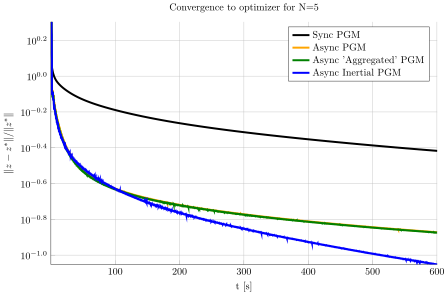

In [68]:
## Plotting residuals
using Plots
pgfplots()
using LaTeXStrings

t = max(length(T1), max(length(T2), max(length(T3), length(T4))))
t_vals = Vector[T1[2:end], T2[2:end], T3[2:end], T4[2:end]]
y_vals = Vector[pgm.RES[2:end], as_pgm.RES[2:end], as_agg_pgm.RES[2:end], as_agg_in_pgm.RES[2:end]]
labels = ["Sync PGM", "Async PGM", "Async 'Aggregated' PGM", "Async Inertial PGM"]

Plot_N10 = plot(t_vals, y_vals, color=[:black :orange :green :blue], xaxis = ("t [s]", font(12, "Helvetica")), 
                 yaxis = (L"$\|z-z^\ast\| / \|z^\ast\|$"),
                 titlefont = font(16, "Helvetica"),
                 legendfont = font(12, "Helvetica"),
                 linewidth = 2,
#                  leg = false,
                 label = labels,
                 title = ("Convergence to optimizer for N=5"),
                 layout=1)
yaxis!(:log10, font(12, "Helvetica"))

In [69]:
## some book-keeping

t_vals = [T1[2:end], T2[2:end], T3[2:end], T4[2:end]];
y_vals = [pgm.RES[2:end], as_pgm.RES[2:end], as_agg_pgm.RES[2:end], as_agg_in_pgm.RES[2:end]];
NoUpdates = [NoUpdates2, NoUpdates3, NoUpdates4];
[pgm.RES[2:end], as_pgm.RES[2:end], as_agg_pgm.RES[2:end], as_agg_in_pgm.RES[2:end]];

type ExecStats
    updateInstants::Array{Array{Float64,1},1}
    values::Array{Array{Float64,1},1}
    NoUpdates::Array{Array{Float64,1},1}
end

Stats_N5 = ExecStats(t_vals, y_vals, NoUpdates);
save("/Users/georgios/Documents/Research/GitHub/AsInFBS/data/Stats_N5.jld", "Stats_N5", Stats_N5);

save("/Users/georgios/Documents/Research/GitHub/AsInFBS/data/AgentCB_N5.jld", "AgentCB_N5", AgentCB);

# save("/Users/georgios/Documents/Research/GitHub/AsInFBS/data/AsAggInPGM_N5.jld", "AsAggInPGM_N5", as_agg_in_pgm);

LoadError: [91mStackOverflowError:[39m

In [13]:
using Plots
pyplot()
using Interpolations

knots = (t_vals[4],)
itp = interpolate(knots, y_vals[4], Gridded(Linear()))

# interpolate on async data points
as_agg_pgm_res = y_vals[3] 
as_agg_in_pgm_res  = itp[t_vals[3]]

using Plots
pyplot()
using LaTeXStrings

labels = ["Async PGM" "Async Inertial PGM"]

Plot_N5 = plot([t_vals[3][1] t_vals[3][1]], [as_agg_pgm_res[1] as_agg_in_pgm_res[1]], color=[:black :blue], xaxis = ("t [s]", font(12, "Helvetica")), 
                 yaxis = (L"$\|z-z^\ast\| / \|z^\ast\|$"),
                 titlefont = font(16, "Helvetica"),
                 legendfont = font(12, "Helvetica"),
                 linewidth = 2,
#                  leg = false,
                 label = labels,
                 title = ("Convergence to optimizer for N=5"),
                 layout=1)
yaxis!(:log10, font(12, "Helvetica"))

# build an animated gif, saving every 10th frame
@gif for i = 2:length(t_vals[3])
    push!(Plot_N5, 1, t_vals[3][i], as_agg_pgm_res[i])
    push!(Plot_N5, 2, t_vals[3][i], as_agg_in_pgm_res[i])
end every 30

# gif(anim, "/Users/georgios/Documents/Research/GitHub/AsInFBS/syncVSasin_fps15.gif", fps = 15)

INFO: Saved animation to /Users/georgios/Documents/Research/GitHub/AsInFBS/tmp.gif


Plots.AnimatedGif("/Users/georgios/Documents/Research/GitHub/AsInFBS/tmp.gif")

In [18]:
Stats_N5.NoUpdates

3-element Array{Array{Float64,1},1}:
 [389.0, 7041.0, 544.0, 544.0, 387.0, 31352.0]
 [388.0, 7037.0, 545.0, 545.0, 391.0, 31356.0]
 [389.0, 7040.0, 545.0, 545.0, 390.0, 31347.0]

In [9]:
println(NoUpdates1)
occurences = cell(11)
for j in 1 : size(NoUpdates1,2)-2
    occurences[j] = []
    for i in 1 : N+1
        occurences[j] = vcat(occurences[j],i*ones(Int(NoUpdates1[i,j+1]),1))
    end
end
mean_occurences = mean(NoUpdates1[1:end-1,:],2)
println(size(occurences[3]))
println(sum(NoUpdates1[:,4]))
println(mean_occurences)

40262-element Array{Float64,1}:
   0.0189575
   0.0385333
   0.0580775
   0.0780743
   0.0863255
   0.0970847
   0.116566 
   0.136268 
   0.156382 
   0.170314 
   0.177556 
   0.195246 
   0.21542  
   ⋮        
 599.833    
 599.835    
 599.856    
 599.874    
 599.891    
 599.913    
 599.914    
 599.929    
 599.95     
 599.972    
 599.991    
 600.002    

In [54]:
getvalue(as_agg_in_pgm.u[3])

18×93 Array{Float64,2}:
 0.0         0.0         0.0         …  0.0      0.0      0.0      0.0    
 9.51403e-8  8.50178e-8  7.41041e-8     2.0057   1.99739  1.99068  1.99383
 1.34221e-7  1.19557e-7  9.98605e-8     3.35796  3.35086  3.34178  3.33105
 1.64789e-7  1.58592e-7  1.30781e-7     2.39595  2.39741  2.39973  2.40708
 1.56048e-7  1.55236e-7  1.30576e-7     2.43837  2.43878  2.4371   2.43186
 2.42378     2.41206     2.32258     …  2.93212  2.94149  2.95114  2.96238
 1.77149     1.75114     1.71399        1.97001  1.97668  1.9835   1.99126
 2.41366     2.4097      2.32917        2.90139  2.9092   2.91735  2.92714
 1.77288     1.75261     1.71563        1.97457  1.98099  1.98759  1.99514
 2.34335     2.32307     2.22485        2.89713  2.90656  2.91617  2.92711
 1.70733     1.68364     1.6421      …  1.91848  1.92504  1.93174  1.93931
 2.31737     2.30358     2.21269        2.85536  2.86316  2.8712   2.88065
 1.69868     1.67286     1.63208        1.91262  1.91887  1.92529  1.9326 
 

In [56]:
AgentCB[3].constraints.inputMin

18×1 Array{Int64,2}:
 -38
 -27
 -30
 -16
 -15
 -13
 -10
 -11
  -9
 -11
  -9
  -9
  -8
 -11
  -8
  -9
  -9
 -21